In [1]:
import os
import numpy as np
from PIL import Image

import pandas as pd
import shutil
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme(style="whitegrid")

from nb_utils import read_params, filter_paths, sweepable_params, parse_logs, visu_diff

# tar -xvzf /Users/pfz/Code/videoseal-eval/1124_vseal_evalbaselines_video.tar.gz
# tar -xvzf /Users/pfz/Code/videoseal-eval/1120_vseal_evalbaselines_simple_bis.tar.gz

In [2]:
# mapping checkpoints to the latex column
checkpoint_mapping = {
    "hidden": r"HiDDeN {\footnotesize\citep{zhu2018hidden}}",
    "mbrs": r"MBRS  {\footnotesize\citep{jia2021mbrs}}",
    "cin": r"CIN {\footnotesize\citep{ma2022towards}}",
    "trustmark": r"TrustMark {\footnotesize\citep{bui2023trustmark}}",
    "wam": r"WAM {\footnotesize\citep{sander2024watermark}}",
    # "videoseal_img": r"\ours\ {\footnotesize (ours)}",
    "videoseal": r"\ours\ {\footnotesize (ours)}",
}
checkpoint_mapping_bis = {
    "hidden": r"HiDDeN \\{\footnotesize\citep{zhu2018hidden}}",
    "mbrs": r"MBRS   \\{\footnotesize\citep{jia2021mbrs}}",
    "cin": r"CIN  \\{\footnotesize\citep{ma2022towards}}",
    "trustmark": r"TrustMark  \\{\footnotesize\citep{bui2023trustmark}}",
    "wam": r"WAM  \\{\footnotesize\citep{sander2024watermark}}",
    # "videoseal_img": r"\ours \\{\footnotesize (ours)}",
    "videoseal": r"\ours\\ {\footnotesize (ours)}",
}

dataset_mapping = {
    "coco": "COCO",
    "moviegen": "MovieGen",
    "sa-v-5s": "SA-V",
    "sa-v-3s": "SA-V",
    "sa-v-1s": "SA-V",
    "sa-1b": "SA-1b",
    "sa-1b-full-resized": "SA-1b"
}

# replace some names
videoseal_ckpts = {
    # "videoseal_img": "/checkpoint/pfz/2025_logs/0226_vseal_ydisc_mult1_bis/_scaling_w_schedule=1_scaling_w=1.0_attenuation=jnd_1_1_hidden_size_multiplier=1/checkpoint500.pth",
    # "videoseal": "/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth",
    # "videoseal": "/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=0_augmentation_config=0/checkpoint200.pth",
    "videoseal_img": "/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth",
    "videoseal": "/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth",
}

def get_ckpt(checkpoint):
    if 'baseline' in checkpoint:
        return checkpoint.split('/')[-1]
    else:
        for key, val in videoseal_ckpts.items():
            if val in checkpoint:
                return key
    exp_name = checkpoint.split('/')[-3]
    sweep_name = checkpoint.split('/')[-2]
    return f"{exp_name}_{sweep_name}"

os.makedirs("tables", exist_ok=True)
os.makedirs("figs", exist_ok=True)

## Robustness tables

##### Long

In [49]:
filters = {}

# load params and filter
all_exp_dir = "/checkpoint/pfz/2025_logs/0306_vseal_eval_baselines_imgmodel"
params = read_params(os.path.join(all_exp_dir, 'params.txt'))

# additional expe
all_exp_dir = "/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas"
params2 = read_params(os.path.join(all_exp_dir, 'params.txt'))
params2 = {k+'2': v for k, v in params2.items()}
# params2 = {}
params = {**params, **params2}

# filter 
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

def get_ckpt(checkpoint):
    if 'baseline' in checkpoint:
        return checkpoint.split('/')[-1]
    else:
        for key, val in videoseal_ckpts.items():
            if val in checkpoint:
                return key
    exp_name = checkpoint.split('/')[-3]
    sweep_name = checkpoint.split('/')[-2]
    return f"{exp_name}_{sweep_name}"

# load dataframes
dfs = {}
list_scaling = []
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param["output_dir"]
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    if len(metrics) < 50:
        print(f"Warning: {path} has only {len(metrics)} samples")
    metrics['is_video'] = param['is_video']    
    metrics['dataset'] = param['dataset']    
    # metrics['scaling_w'] = param['scaling_w']    
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")

paths = dfs.keys()
df = pd.concat(dfs)
measures = [
    "checkpoint",
    "dataset",
    # "scaling_w",
    "psnr", "ssim", "lpips",
    "vmaf", 
    "embed_time", "extract_time",
]
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]
for aug in augs:
    measures.append(f'bit_acc_{aug}')
    measures.append(f'log_pvalue_{aug}')
    measures.append(f'capacity_{aug}')

df = df[measures]
df = df.groupby(['checkpoint', "dataset"]).mean()
df = df.reset_index()

# split by dataset
dataset_dfs = []
for dataset in df['dataset'].unique():
    dataset_dfs.append(df[df['dataset'] == dataset].copy())

checkpoints = list(checkpoint_mapping.keys())
new_augs = augs

for dataset_df in dataset_dfs:

    dataset = dataset_df['dataset'].values[0]

    # header
    latex_header = r"""
\begin{tabular}{c""" + " *{2}{>{\centering\\arraybackslash}p{1.3cm}}" * len(checkpoints) + "}"
    latex_header += r"""
\toprule
& """ + " & ".join([f"\\multicolumn{{2}}{{c}}{{\\shortstack{{{checkpoint_mapping[checkpoint]}}}}}" for checkpoint in checkpoints]) + r""" \\
""" + " ".join(["\\cmidrule(lr){{{}}}".format(f"{i*2+2}-{i*2+3}") for i in range(len(checkpoints))]) + r"""
& """ + " & ".join([f"\\multicolumn{{2}}{{p{{1cm}}}}{{Bit~acc.~\\footnotesize{{($\\uparrow$)}}/~$\\logpval$~\\footnotesize{{($\\downarrow$)}}}}" for _ in checkpoints]) + r""" \\
\midrule
"""

    # valuemetric / geometric split
    
    # geometric = ["rotate", "perspective", "crop", "identity", "horizontal", "(jpeg_crop", "(h264_crop"]
    # valuemetric_augs = []
    # geometric_augs = []
    # for aug in new_augs:
    #     starts_with_geometric = any([aug.lower().startswith(vm) for vm in geometric])
    #     if starts_with_geometric:
    #         geometric_augs.append(aug)
    #     else:
    #         valuemetric_augs.append(aug)

    # rows

    labels = {
        # "valuemetric": valuemetric_augs,
        # "geometric": geometric_augs,
        "all": new_augs,
    }
    for label, augs_to_print in labels.items():

        latex_rows = []
        for aug in augs_to_print:
            aug_str = aug.replace("_", " ")
            if aug_str.endswith(" 0"):
                aug_str = aug_str[:-2]
            if aug_str.endswith(" -1"):
                aug_str = aug_str[:-3]
            latex_row = f"{aug_str} & "
            all_vals = []
            for checkpoint in checkpoints:
                subdf = dataset_df[(dataset_df["checkpoint"] == checkpoint)]
                all_vals += [f"{subdf[f'bit_acc_{aug}'].values[0]:.2f}"]
                all_vals += [f"{-subdf[f'log_pvalue_{aug}'].values[0]:.1f}"]
            latex_row +=  " & ".join(all_vals) + " \\\\"
            if not "nan" in latex_row:
                latex_rows.append(latex_row)
        latex_rows = "\n".join(latex_rows)

        # footer
        latex_footer = r"""
        \bottomrule
        \end{tabular}
        """

        # Combine the header, rows, and footer
        latex_table = latex_header + latex_rows + latex_footer

        # Print the LaTeX table
        print(latex_table)

        # save them in a file
        with open(f"tables/robustness-{label}-{dataset}.tex", "w") as f:
            f.write(latex_table)

<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_4011090/2496748549.py:90: SyntaxWarning: invalid escape sequence '\c'
  \begin{tabular}{c""" + " *{2}{>{\centering\\arraybackslash}p{1.3cm}}" * len(checkpoints) + "}"


scaling_w: [0.2, 'none']
checkpoint: ['/checkpoint/pfz/2025_logs/0226_vseal_ydisc_mult1_bis/_scaling_w_schedule=1_scaling_w=1.0_attenuation=jnd_1_1_hidden_size_multiplier=1/checkpoint500.pth', '/checkpoint/pfz/2025_logs/0301_vseal_ep500_ftvid_complete_morepercep/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', '/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', 'baselines/trustmark', 'baselines/hidden', 'baselines/mbrs', 'baselines/cin', 'baselines/wam', '/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth']
num_samples: [100.0, 1000.0]
dataset: ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen']
is_video: ['false', 'true']
output_dir: ['/checkpoint/pfz/2025_logs/0306_vseal_eval_baselines_imgmodel/_scalin

Errors: 0 / 40

\begin{tabular}{c *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}}}
\toprule
& \multicolumn{2}{c}{\shortstack{HiDDeN {\footnotesize\citep{zhu2018hidden}}}} & \multicolumn{2}{c}{\shortstack{MBRS  {\footnotesize\citep{jia2021mbrs}}}} & \multicolumn{2}{c}{\shortstack{CIN {\footnotesize\citep{ma2022towards}}}} & \multicolumn{2}{c}{\shortstack{TrustMark {\footnotesize\citep{bui2023trustmark}}}} & \multicolumn{2}{c}{\shortstack{WAM {\footnotesize\citep{sander2024watermark}}}} & \multicolumn{2}{c}{\shortstack{\ours\ {\footnotesize (ours)}}} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11} \cmidrule(lr){12-13}
& \multicolumn{2}{p{1cm}}{Bit~acc.~\footnotesize{($\uparrow$)}/~$\logpval$~\footnotesize{($\downarrow$)}} & \multi

##### Short SA-1b and SA-V

In [50]:
# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

def get_ckpt(checkpoint):
    if 'baseline' in checkpoint:
        return checkpoint.split('/')[-1]
    else:
        for key, val in videoseal_ckpts.items():
            if val in checkpoint:
                return key
    exp_name = checkpoint.split('/')[-3]
    sweep_name = checkpoint.split('/')[-2]
    return f"{exp_name}_{sweep_name}"


# load dataframes
dfs = {}
list_scaling = []
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param["output_dir"]
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['is_video'] = param['is_video']    
    metrics['dataset'] = param['dataset']    
    # metrics['scaling_w'] = param['scaling_w']    
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")

paths = dfs.keys()
df = pd.concat(dfs)
measures = [
    "checkpoint",
    "dataset",
    # "scaling_w",
    "psnr", "ssim", 
    "vmaf", 
    "embed_time", "extract_time",
]
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]
for aug in augs:
    measures.append(f'bit_acc_{aug}')
    measures.append(f'log_pvalue_{aug}')
    measures.append(f'capacity_{aug}')

df = df[measures]
df = df.groupby(['checkpoint', "dataset"]).mean()
df = df.reset_index()

# split by dataset
dataset_dfs = []
for dataset in df['dataset'].unique():
    # if dataset == "coco" or dataset == "moviegen":
        # continue
    dataset_dfs.append(df[df['dataset'] == dataset].copy())

checkpoints = list(checkpoint_mapping.keys())
new_augs = augs


# header
latex_header = r"""
\begin{tabular}{rr""" + " *{2}{>{\centering\\arraybackslash}p{1.3cm}}" * len(checkpoints) + "}"
latex_header += r"""
\toprule
& & """ + " & ".join([f"\\multicolumn{{2}}{{c}}{{\\shortstack{{{checkpoint_mapping[checkpoint]}}}}}" for checkpoint in checkpoints]) + r""" \\
""" + " ".join(["\\cmidrule(lr){{{}}}".format(f"{i*2+3}-{i*2+4}") for i in range(len(checkpoints))]) + r"""
& & """ + " & ".join([f"\\multicolumn{{2}}{{p{{1cm}}}}{{Bit~acc.~\\footnotesize{{($\\uparrow$)}}/~$\\logpval$\\footnotesize{{($\\downarrow$)}}}}" for _ in checkpoints]) + r""" \\
\midrule
"""

latex_rows = []
for dataset_df in dataset_dfs:

    dataset = dataset_df['dataset'].values[0]

    # Define augmentation categories
    geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
    identitic = ["identity"]
    compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
    valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]  # Corrected to actual value-changing augmentations
    combined = ["("]

    # Map to actual augmentations in the dataset
    identity_augs = [aug for aug in augs if any(aug.lower().startswith(i) for i in identitic)]
    geometric_augs = [aug for aug in augs if any(aug.lower().startswith(g) for g in geometric)]
    compression_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in compression)]
    valuemetric_augs = [aug for aug in augs if any(aug.lower().startswith(v) for v in valuemetric)]
    parenthesis_augs = [aug for aug in augs if aug.startswith("(")]

    # Now your categories dictionary will work correctly
    categories = {
        "Identity": identity_augs,
        "Valuemetric": valuemetric_augs,
        "Geometric": geometric_augs,
        "Compression": compression_augs,
        "Combined": parenthesis_augs
    }

    # Function to calculate average for a list of augmentations
    def calculate_average(dataset_df, augs):
        avg_bit_acc = dataset_df[[f'bit_acc_{aug}' for aug in augs]].mean(axis=1)
        avg_log_pvalue = dataset_df[[f'log_pvalue_{aug}' for aug in augs]].mean(axis=1)
        return avg_bit_acc, avg_log_pvalue

    # "\multirow{4}{*}{\rotatebox[origin=c]{90}{Image}}"
    dataset_name = dataset_mapping[dataset]
    latex_row = f"\multirow{{{len(categories)}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{dataset_name}}}}} "
    for category, augs_list in categories.items():
        latex_row += f"& {category} & "
        all_vals = []
        for checkpoint in checkpoints:
            subdf = dataset_df[dataset_df["checkpoint"] == checkpoint]
            avg_bit_acc, avg_log_pvalue = calculate_average(subdf, augs_list)
            all_vals += [f"{avg_bit_acc.mean():.2f}"]
            all_vals += [f"{-avg_log_pvalue.mean():.1f}"]
        latex_row += " & ".join(all_vals) + " \\\\ \n"
    latex_row = latex_row[:-1]  # remove last newline
    latex_row += "\\ \n \midrule"
    latex_rows.append(latex_row)
latex_rows[-1] = latex_rows[-1].replace("\\ \n \midrule", "")  # remove last \midrule
latex_rows = "\n".join(latex_rows)

# Footer
latex_footer = r"""
\bottomrule
\end{tabular}
"""

# Combine the header, rows, and footer
latex_table = latex_header + latex_rows + latex_footer

# Print the LaTeX table
print(f"Dataset: {dataset_df['dataset'].values[0]}")
print(latex_table)

# save them in a file
with open(f"tables/robustness-sa-1b-sa-v.tex", "w") as f:
    f.write(latex_table)

<>:72: SyntaxWarning: invalid escape sequence '\c'
<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:130: SyntaxWarning: invalid escape sequence '\m'
<>:72: SyntaxWarning: invalid escape sequence '\c'
<>:117: SyntaxWarning: invalid escape sequence '\m'
<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:130: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_4011090/937192857.py:72: SyntaxWarning: invalid escape sequence '\c'
  \begin{tabular}{rr""" + " *{2}{>{\centering\\arraybackslash}p{1.3cm}}" * len(checkpoints) + "}"
/tmp/ipykernel_4011090/937192857.py:117: SyntaxWarning: invalid escape sequence '\m'
  latex_row = f"\multirow{{{len(categories)}}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{dataset_name}}}}} "
/tmp/ipykernel_4011090/937192857.py:128: SyntaxWarning: invalid escape sequence '\m'
  latex_row += "\\ \n \midrule"
/tmp/ipykernel_4011090/937192857.py:130: SyntaxWarning: invalid escape sequence '\m'
  latex_rows[-

scaling_w: [0.2, 'none']
checkpoint: ['/checkpoint/pfz/2025_logs/0226_vseal_ydisc_mult1_bis/_scaling_w_schedule=1_scaling_w=1.0_attenuation=jnd_1_1_hidden_size_multiplier=1/checkpoint500.pth', '/checkpoint/pfz/2025_logs/0301_vseal_ep500_ftvid_complete_morepercep/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', '/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', 'baselines/trustmark', 'baselines/hidden', 'baselines/mbrs', 'baselines/cin', 'baselines/wam', '/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth']
num_samples: [100.0, 1000.0]
dataset: ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen']
is_video: ['false', 'true']
output_dir: ['/checkpoint/pfz/2025_logs/0306_vseal_eval_baselines_imgmodel/_scalin

Errors: 0 / 40
Dataset: sa-v-3s

\begin{tabular}{rr *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}} *{2}{>{\centering\arraybackslash}p{1.3cm}}}
\toprule
& & \multicolumn{2}{c}{\shortstack{HiDDeN {\footnotesize\citep{zhu2018hidden}}}} & \multicolumn{2}{c}{\shortstack{MBRS  {\footnotesize\citep{jia2021mbrs}}}} & \multicolumn{2}{c}{\shortstack{CIN {\footnotesize\citep{ma2022towards}}}} & \multicolumn{2}{c}{\shortstack{TrustMark {\footnotesize\citep{bui2023trustmark}}}} & \multicolumn{2}{c}{\shortstack{WAM {\footnotesize\citep{sander2024watermark}}}} & \multicolumn{2}{c}{\shortstack{\ours\ {\footnotesize (ours)}}} \\
\cmidrule(lr){3-4} \cmidrule(lr){5-6} \cmidrule(lr){7-8} \cmidrule(lr){9-10} \cmidrule(lr){11-12} \cmidrule(lr){13-14}
& & \multicolumn{2}{p{1cm}}{Bit~acc.~\footnotesize{($\uparrow$)}/~$\logpval$\footnotesize{($\

## Imperceptibility tables

In [ ]:

# filter 
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

def get_ckpt(checkpoint):
    if 'baseline' in checkpoint:
        return checkpoint.split('/')[-1]
    else:
        for key, val in videoseal_ckpts.items():
            if val in checkpoint:
                return key
    exp_name = checkpoint.split('/')[-3]
    sweep_name = checkpoint.split('/')[-2]
    return f"{exp_name}_{sweep_name}"

# load dataframes
dfs = {}
list_scaling = []
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param["output_dir"]
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['is_video'] = param['is_video']    
    metrics['dataset'] = param['dataset']    
    # metrics['scaling_w'] = param['scaling_w']    
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")

paths = dfs.keys()
df = pd.concat(dfs)
df = df[df['checkpoint'] != 'wam_noattenuation']
measures = [
    "checkpoint",
    "is_video",
    "dataset",
    # "scaling_w",
    "psnr", "ssim", "vmaf", "lpips"
]
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]
for aug in augs:
    measures.append(f'bit_acc_{aug}')
    measures.append(f'log_pvalue_{aug}')
    measures.append(f'capacity_{aug}')

df = df[measures]
df = df.groupby(['checkpoint', "dataset", "is_video"]).mean()
df = df.groupby(['checkpoint', "is_video"]).mean()
df = df.reset_index()

# only keep checkpoints that are in the mapping
df = df[df["checkpoint"].isin(checkpoint_mapping_bis.keys())]

# video_df = df[df["dataset"] == "sa-v-5s"].copy()
# image_df = df[df["dataset"] == "sa-1b"].copy()
# video_df = df[df["dataset"] == "sa-v-3s"].copy()
# image_df = df[df["dataset"] == "sa-1b-full-resized"].copy()
video_df = df[df["is_video"] == "true"].copy()
image_df = df[df["is_video"] == "false"].copy()

# reorder rows of df such that the order of checkpoints is the same as in checkpoint_mapping_bis
image_df["checkpoint"] = pd.Categorical(image_df["checkpoint"], checkpoint_mapping_bis.keys())
image_df = image_df.sort_values("checkpoint")
video_df["checkpoint"] = pd.Categorical(video_df["checkpoint"], checkpoint_mapping_bis.keys())
video_df = video_df.sort_values("checkpoint")

# # add dummy lpips numbers
# image_df["lpips"] = 0.07 * np.random.rand(len(image_df))
# video_df["lpips"] = 0.07 * np.random.rand(len(video_df))

# print table
latex_table = r"""
\begin{tabular}{rr *{6}{c}}
    \toprule
    & & """ + " & ".join(
    [f"\\rotatebox[origin=l]{{0}}{{\\shortstack[c]{{{checkpoint_mapping_bis[cp]}}}}}" for cp in checkpoint_mapping_bis.keys()]
) + r""" \\
    \midrule
    \multirow{3}{*}{\rotatebox[origin=c]{90}{Image}} 
    & SSIM ($\uparrow$) & """ + " & ".join(f"{row:.3f}" for row in image_df["ssim"]) + r""" \\
    & LPIPS ($\downarrow$) & """ + " & ".join(f"{row:.3f}" for row in image_df["lpips"]) + r""" \\
    & PSNR ($\uparrow$) & """ + " & ".join(f"{row:.2f}" for row in image_df["psnr"]) + r""" \\
    \midrule
    \multirow{4}{*}{\rotatebox[origin=c]{90}{Video}}     
    & SSIM ($\uparrow$) & """ + " & ".join(f"{row:.3f}" for row in video_df["ssim"]) + r""" \\
    & LPIPS ($\downarrow$) & """ + " & ".join(f"{row:.3f}" for row in video_df["lpips"]) + r""" \\
    & PSNR ($\uparrow$) & """ + " & ".join(f"{row:.2f}" for row in video_df["psnr"]) + r""" \\
    & VMAF ($\uparrow$) & """ + " & ".join(f"{row:.2f}" for row in video_df["vmaf"]) + r""" \\
    \bottomrule
\end{tabular}
"""

print(latex_table)

# save them in a file
with open(f"tables/quality-img-vid.tex", "w") as f:
    f.write(latex_table)


scaling_w: [0.2, 'none']
checkpoint: ['/checkpoint/pfz/2025_logs/0226_vseal_ydisc_mult1_bis/_scaling_w_schedule=1_scaling_w=1.0_attenuation=jnd_1_1_hidden_size_multiplier=1/checkpoint500.pth', '/checkpoint/pfz/2025_logs/0301_vseal_ep500_ftvid_complete_morepercep/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', '/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', 'baselines/trustmark', 'baselines/hidden', 'baselines/mbrs', 'baselines/cin', 'baselines/wam', '/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth']
num_samples: [100.0, 1000.0]
dataset: ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen']
is_video: ['false', 'true']
output_dir: ['/checkpoint/pfz/2025_logs/0306_vseal_eval_baselines_imgmodel/_scalin

Errors: 0 / 40

\begin{tabular}{rr *{6}{c}}
    \toprule
    & & \rotatebox[origin=l]{0}{\shortstack[c]{HiDDeN \\{\footnotesize\citep{zhu2018hidden}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{MBRS   \\{\footnotesize\citep{jia2021mbrs}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{CIN  \\{\footnotesize\citep{ma2022towards}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{TrustMark  \\{\footnotesize\citep{bui2023trustmark}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{WAM  \\{\footnotesize\citep{sander2024watermark}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{\ours\\ {\footnotesize (ours)}}} \\
    \midrule
    \multirow{3}{*}{\rotatebox[origin=c]{90}{Image}} 
    & SSIM ($\uparrow$) & 0.877 & 0.996 & 0.995 & 0.994 & 0.983 & 0.994 \\
    & LPIPS ($\downarrow$) & 0.222 & 0.003 & 0.015 & 0.002 & 0.034 & 0.003 \\
    & PSNR ($\uparrow$) & 30.37 & 45.93 & 45.09 & 42.58 & 38.69 & 43.97 \\
    \midrule
    \multirow{4}{*}{\rotatebox[origin=c]{90}{Video}}     
    & SSIM ($\uparrow$) & 0.855 & 0.994 & 

In [67]:

# filter 
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

def get_ckpt(checkpoint):
    if 'baseline' in checkpoint:
        return checkpoint.split('/')[-1]
    else:
        for key, val in videoseal_ckpts.items():
            if val in checkpoint:
                return key
    exp_name = checkpoint.split('/')[-3]
    sweep_name = checkpoint.split('/')[-2]
    return f"{exp_name}_{sweep_name}"

# load dataframes
dfs = {}
list_scaling = []
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param["output_dir"]
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['is_video'] = param['is_video']    
    metrics['dataset'] = param['dataset']    
    # metrics['scaling_w'] = param['scaling_w']    
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")


paths = dfs.keys()
df = pd.concat(dfs)
df = df[df['checkpoint'] != 'wam_noattenuation']
measures = [
    "checkpoint",
    # "is_video",
    "dataset",
    # "scaling_w",
    "psnr", "ssim", "vmaf", "lpips"
]
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]
for aug in augs:
    measures.append(f'bit_acc_{aug}')
    measures.append(f'log_pvalue_{aug}')
    measures.append(f'capacity_{aug}')

df = df[measures]
df = df.groupby(['checkpoint', "dataset"]).mean()
df = df.reset_index()

# only keep checkpoints that are in the mapping
df = df[df["checkpoint"].isin(checkpoint_mapping_bis.keys())]

# df1 = df[df["dataset"] == "sa-v-3s"].copy()
# df2 = df[df["dataset"] == "moviegen"].copy()
# df1 = df[df["dataset"] == "sa-v-3s"].copy()
# df2 = df[df["dataset"] == "moviegen"].copy()
df1 = df[df["dataset"] == "coco"].copy()
df2 = df[df["dataset"] == "sa-1b-full-resized"].copy()


# reorder rows of df such that the order of checkpoints is the same as in checkpoint_mapping_bis
df2["checkpoint"] = pd.Categorical(df2["checkpoint"], checkpoint_mapping_bis.keys())
df2 = df2.sort_values("checkpoint")
df1["checkpoint"] = pd.Categorical(df1["checkpoint"], checkpoint_mapping_bis.keys())
df1 = df1.sort_values("checkpoint")

# # add dummy lpips numbers
# df2["lpips"] = 0.07 * np.random.rand(len(df2))
# df1["lpips"] = 0.07 * np.random.rand(len(df1))

# print table
latex_table = r"""
\begin{tabular}{rr *{6}{c}}
    \toprule
    & & """ + " & ".join(
    [f"\\rotatebox[origin=l]{{0}}{{\\shortstack[c]{{{checkpoint_mapping_bis[cp]}}}}}" for cp in checkpoint_mapping_bis.keys()]
) + r""" \\
    \midrule
    \multirow{3}{*}{\rotatebox[origin=c]{90}{SA-1b}} 
    & SSIM ($\uparrow$) & """ + " & ".join(f"{row:.3f}" for row in df2["ssim"]) + r""" \\
    & LPIPS ($\downarrow$) & """ + " & ".join(f"{row:.3f}" for row in df2["lpips"]) + r""" \\
    & PSNR ($\uparrow$) & """ + " & ".join(f"{row:.2f}" for row in df2["psnr"]) + r""" \\
    \midrule
    \multirow{4}{*}{\rotatebox[origin=c]{90}{COCO}}     
    & SSIM ($\uparrow$) & """ + " & ".join(f"{row:.3f}" for row in df1["ssim"]) + r""" \\
    & LPIPS ($\downarrow$) & """ + " & ".join(f"{row:.3f}" for row in df1["lpips"]) + r""" \\
    & PSNR ($\uparrow$) & """ + " & ".join(f"{row:.2f}" for row in df1["psnr"]) + r""" \\
    \bottomrule
\end{tabular}
"""

print(latex_table)

# save them in a file
with open(f"tables/quality-coco-sa1b.tex", "w") as f:
    f.write(latex_table)


scaling_w: [0.2, 'none']
checkpoint: ['/checkpoint/pfz/2025_logs/0226_vseal_ydisc_mult1_bis/_scaling_w_schedule=1_scaling_w=1.0_attenuation=jnd_1_1_hidden_size_multiplier=1/checkpoint500.pth', '/checkpoint/pfz/2025_logs/0301_vseal_ep500_ftvid_complete_morepercep/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', '/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', 'baselines/trustmark', 'baselines/hidden', 'baselines/mbrs', 'baselines/cin', 'baselines/wam', '/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth']
num_samples: [100.0, 1000.0]
dataset: ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen']
is_video: ['false', 'true']
output_dir: ['/checkpoint/pfz/2025_logs/0306_vseal_eval_baselines_imgmodel/_scalin

Errors: 0 / 40

\begin{tabular}{rr *{6}{c}}
    \toprule
    & & \rotatebox[origin=l]{0}{\shortstack[c]{HiDDeN \\{\footnotesize\citep{zhu2018hidden}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{MBRS   \\{\footnotesize\citep{jia2021mbrs}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{CIN  \\{\footnotesize\citep{ma2022towards}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{TrustMark  \\{\footnotesize\citep{bui2023trustmark}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{WAM  \\{\footnotesize\citep{sander2024watermark}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{\ours\\ {\footnotesize (ours)}}} \\
    \midrule
    \multirow{3}{*}{\rotatebox[origin=c]{90}{SA-1b}} 
    & SSIM ($\uparrow$) & 0.924 & 0.997 & 0.996 & 0.995 & 0.986 & 0.995 \\
    & LPIPS ($\downarrow$) & 0.243 & 0.003 & 0.020 & 0.002 & 0.039 & 0.002 \\
    & PSNR ($\uparrow$) & 30.39 & 45.82 & 44.87 & 42.35 & 38.61 & 43.75 \\
    \midrule
    \multirow{4}{*}{\rotatebox[origin=c]{90}{COCO}}     
    & SSIM ($\uparrow$) & 0.829 & 0.995 & 0

## IMages

In [70]:

output_dir = "figs/appendix-images"

# load params and filter
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f"{k}: {v}")

def get_ckpt(checkpoint):
    if 'baseline' in checkpoint:
        return checkpoint.split('/')[-1]
    else:
        for key, val in videoseal_ckpts.items():
            if val in checkpoint:
                return key
    exp_name = checkpoint.split('/')[-3]
    sweep_name = checkpoint.split('/')[-2]
    return f"{exp_name}_{sweep_name}"

def get_diff(img_ori, img_wm):
    img_ori = np.array(img_ori) / 255.
    img_wm = np.array(img_wm) / 255.
    diff = np.abs( img_ori - img_wm ) * 255
    diff = Image.fromarray(diff.clip(0, 255).astype(np.uint8))
    return diff

# load and create diffs
total = 10
from concurrent.futures import ThreadPoolExecutor
errors = []
def process_path(path):
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, '000_val_0_ori.png'))
    
    if not path_exists:
        errors.append(path)
        return
    
    checkpoint = get_ckpt(param['checkpoint'])
    dataset = param['dataset'].replace('-full-resized', '')
    save_dir = os.path.join(output_dir, f"{dataset}_{checkpoint}")
    
    for ii in range(total):
        img_ori = os.path.join(exp_dir, f'{ii:03d}_val_0_ori.png')
        img_wm = os.path.join(exp_dir, f'{ii:03d}_val_1_wm.png')
        if os.path.exists(img_ori):
            img_ori = Image.open(img_ori).convert("RGB")
            img_wm = Image.open(img_wm).convert("RGB")
            diff = get_diff(img_ori, img_wm)
            # brighten the diff
            diff = diff.point(lambda p: p * 30.0)
            os.makedirs(save_dir, exist_ok=True)
            # diff = diff.resize((diff.width // 4, diff.height // 4))
            # img_ori = img_ori.resize((img_ori.width // 4, img_ori.height // 4))
            # img_wm = img_wm.resize((img_wm.width // 4, img_wm.height // 4))
            # cut images by //8 in width
            diff = diff.crop((1, 1, diff.width // 8 + 1, diff.height-1))
            img_ori = img_ori.crop((1, 1, img_ori.width // 8 + 1, img_ori.height-1))
            img_wm = img_wm.crop((1, 1, img_wm.width // 8 + 1, img_wm.height-1))
            diff.save(os.path.join(save_dir, f'{ii}_diff.jpg'))
            img_ori.save(os.path.join(save_dir, f'{ii}_ori.jpg'))
            img_wm.save(os.path.join(save_dir, f'{ii}_wm.jpg'))

# Use ThreadPoolExecutor to parallelize the processing
with ThreadPoolExecutor() as executor:
    executor.map(process_path, paths)

scaling_w: [0.2, 'none']
checkpoint: ['/checkpoint/pfz/2025_logs/0226_vseal_ydisc_mult1_bis/_scaling_w_schedule=1_scaling_w=1.0_attenuation=jnd_1_1_hidden_size_multiplier=1/checkpoint500.pth', '/checkpoint/pfz/2025_logs/0301_vseal_ep500_ftvid_complete_morepercep/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', '/checkpoint/pfz/2025_logs/0303_vseal_ep500_ftvid_complete/_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', 'baselines/trustmark', 'baselines/hidden', 'baselines/mbrs', 'baselines/cin', 'baselines/wam', '/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth']
num_samples: [100.0, 1000.0]
dataset: ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen']
is_video: ['false', 'true']
output_dir: ['/checkpoint/pfz/2025_logs/0306_vseal_eval_baselines_imgmodel/_scalin

In [53]:
import os

# Define the checkpoint mapping
# checkpoint_mapping = {
#     "hidden": r"HiDDeN\\  {\footnotesize\citep{zhu2018hidden}}",
#     "mbrs": r"MBRS\\  {\footnotesize\citep{jia2021mbrs}}",
#     "cin": r"CIN\\  {\footnotesize\citep{ma2022towards}}",
#     "trustmark": r"TrustMark\\  {\footnotesize\citep{bui2023trustmark}}",
#     "wam": r"WAM\\  {\footnotesize\citep{sander2024watermark}}",
#     "videoseal0.1": r"\ours\\ {\footnotesize (ours)}",
#     # "videoseal0.4": r"\ours\\ (ours2)"
# }

checkpoint_mapping = {
    "hidden": r"HiDDeN",
    "mbrs": r"MBRS",
    "cin": r"CIN",
    "trustmark": r"TrustMark",
    "wam": r"WAM",
    "videoseal": r"\ours",
    # "videoseal0.4": r"\ours\\ (ours2)"
}

checkpoints = list(checkpoint_mapping.keys())
dataset = "sa-1b"  # Replace with your actual dataset name

for dataset in ["sa-1b", "sa-v-3s", "moviegen", "coco"]:

    # Define the image paths
    image_paths = {
        "original": f"{output_dir}" + "/{dataset}_{method}/{ii}_ori.jpg",
        "watermarked": f"{output_dir}" + "/{dataset}_{method}/{ii}_wm.jpg",
        "diff": f"{output_dir}" + "/{dataset}_{method}/{ii}_diff.jpg"
    }

    if dataset == "sa-1b" or dataset == "coco":
        img_width = 1.0 / (len(checkpoints) + 1)

        # Start constructing the LaTeX table
        latex_table = r"""
\centering
\scriptsize
\newcommand{\imwidth}{""" + f"{img_width:.2f}" + r"""\textwidth}
\setlength{\tabcolsep}{0pt}
\begin{tabular}{c@{\hskip 2pt}""" + "c" * len(checkpoint_mapping) + r"""}
\toprule
Original & """ + " & ".join([f"\\shortstack{{{checkpoint_mapping[checkpoint]}}}" for checkpoint in checkpoints]) + r""" \\
\midrule"""

        # Iterate over the checkpoint mapping to fill in the table
        for ii in range(total):
            wm_row = ""
            diff_row = ""
            for method, latex_name in checkpoint_mapping.items():
                ori_path = image_paths["original"].format(dataset=dataset, method=method, ii=ii)
                wm_path = image_paths["watermarked"].format(dataset=dataset, method=method, ii=ii)
                diff_path = image_paths["diff"].format(dataset=dataset, method=method, ii=ii)
                if len(wm_row) == 0:
                    wm_row += "\includegraphics[width=\imwidth]{" + ori_path + "} & \n"
                    diff_row += " & \n"
                wm_row += "\includegraphics[width=\imwidth]{" + wm_path + "} & \n"
                diff_row += "\includegraphics[width=\imwidth]{" + diff_path + "} & \n"
            latex_table += wm_row[:-3] + r"\\" + diff_row[:-3] + r"\\"
            if ii != total - 1:
                latex_table += r"\rule{0pt}{6ex}"

        # Close the table
        latex_table += r"""
\end{tabular}
"""

        # Print the LaTeX table
        print(latex_table)

    if dataset.startswith("sa-v") or dataset == "moviegen":

        ori_path = image_paths["original"].format(dataset=dataset, method="hidden", ii=0)

        # Start constructing the LaTeX table
        latex_table = r"""
\centering
\scriptsize
\setlength{\tabcolsep}{0pt}
\begin{tabular}{c@{\hskip 2pt}c}
\toprule
\rotatebox[origin=l]{90}{Original} & \includegraphics[width=0.95\textwidth]{{""" + ori_path + r"""}} \\
\midrule"""
        # Iterate over the checkpoint mapping to fill in the table
        for ii in range(1):
            wm_row = ""
            diff_row = ""
            for method, latex_name in checkpoint_mapping.items():
                # wm_row += r"\multirow{2}{*}{\rotatebox[origin=c]{90}{" + latex_name + r"}} & \includegraphics[width=0.95\textwidth]{" + wm_path + r"} \\ \n"
                # diff_row += r" & \includegraphics[width=0.95\textwidth]{" + diff_path + r"} \\ \n"
                # latex_table += wm_row + diff_row + r"\midrule"
                wm_row += r"""
\multirow{2}{*}{\rotatebox[origin=c]{90}{""" + latex_name + r"""}} & \includegraphics[width=0.95\textwidth]{{""" + image_paths["watermarked"].format(dataset=dataset, method=method, ii=ii) + r"""}} \\
 & \includegraphics[width=0.95\textwidth]{{""" + image_paths["diff"].format(dataset=dataset, method=method, ii=ii) + r"""}} \\
\midrule"""
            latex_table += wm_row

        # Close the table
        latex_table += r"""
\end{tabular}
"""

        # Print the LaTeX table
        print(latex_table)

    # save in /private/home/pfz/09-videoseal/plotlogs/figs/appendix-images
    with open(f"{output_dir}/{dataset}-table.tex", "w") as f:
        f.write(latex_table)


\centering
\scriptsize
\newcommand{\imwidth}{0.14\textwidth}
\setlength{\tabcolsep}{0pt}
\begin{tabular}{c@{\hskip 2pt}cccccc}
\toprule
Original & \shortstack{HiDDeN} & \shortstack{MBRS} & \shortstack{CIN} & \shortstack{TrustMark} & \shortstack{WAM} & \shortstack{\ours} \\
\midrule\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_hidden/0_ori.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_hidden/0_wm.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_mbrs/0_wm.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_cin/0_wm.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_trustmark/0_wm.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_wam/0_wm.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_videoseal/0_wm.jpg} \\ & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_hidden/0_diff.jpg} & 
\includegraphics[width=\imwidth]{figs/appendix-images/sa-1b_mbrs/0_diff.j

<>:59: SyntaxWarning: invalid escape sequence '\i'
<>:61: SyntaxWarning: invalid escape sequence '\i'
<>:62: SyntaxWarning: invalid escape sequence '\i'
<>:59: SyntaxWarning: invalid escape sequence '\i'
<>:61: SyntaxWarning: invalid escape sequence '\i'
<>:62: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_4011090/3187932285.py:59: SyntaxWarning: invalid escape sequence '\i'
  wm_row += "\includegraphics[width=\imwidth]{" + ori_path + "} & \n"
/tmp/ipykernel_4011090/3187932285.py:61: SyntaxWarning: invalid escape sequence '\i'
  wm_row += "\includegraphics[width=\imwidth]{" + wm_path + "} & \n"
/tmp/ipykernel_4011090/3187932285.py:62: SyntaxWarning: invalid escape sequence '\i'
  diff_row += "\includegraphics[width=\imwidth]{" + diff_path + "} & \n"


In [54]:
# zip and download
os.system(f"cd {output_dir} && zip -r diffs.zip *; mv diffs.zip ..")



  adding: coco-table.tex (deflated 90%)
  adding: moviegen-table.tex (deflated 81%)
  adding: moviegen_cin/ (stored 0%)
  adding: moviegen_cin/0_diff.jpg

 (deflated 0%)
  adding: moviegen_cin/0_ori.jpg (deflated 6%)
  adding: moviegen_cin/0_wm.jpg (deflated 4%)
  adding: moviegen_cin/1_diff.jpg (deflated 1%)
  adding: moviegen_cin/1_ori.jpg (deflated 5%)
  adding: moviegen_cin/1_wm.jpg (deflated 3%)
  adding: moviegen_cin/2_diff.jpg (deflated 0%)
  adding: moviegen_cin/2_ori.jpg (deflated 15%)
  adding: moviegen_cin/2_wm.jpg (deflated 7%)
  adding: moviegen_cin/3_diff.jpg (deflated 1%)
  adding: moviegen_cin/3_ori.jpg (deflated 7%)
  adding: moviegen_cin/3_wm.jpg (deflated 5%)
  adding: moviegen_hidden/ (stored 0%)
  adding: moviegen_hidden/0_diff.jpg (deflated 1%)
  adding: moviegen_hidden/0_ori.jpg (deflated 6%)
  adding: moviegen_hidden/0_wm.jpg (deflated 3%)
  adding: moviegen_hidden/1_diff.jpg (deflated 1%)
  adding: moviegen_hidden/1_ori.jpg (deflated 5%)
  adding: moviegen_hidden/1_wm.jpg (deflated 2%)
  adding: moviegen_hidden/2_diff.jpg (deflated 1%)
  adding: moviegen_hidden/2_ori.jpg (deflated 15%)
  adding: moviegen_hidden/2

0

In [ ]:
# import os
# import cv2
# import numpy as np
# from PIL import Image
# from concurrent.futures import ThreadPoolExecutor
# from pathlib import Path

# # Define paths
# video_base_dir = "/checkpoint/pfz/2025_logs/0227_vseal_eval_baselines/hippovid"
# output_dir = "figs/video-frames"
# os.makedirs(output_dir, exist_ok=True)

# # Define methods and their videos
# methods = ["cin", "hidden", "mbrs", "trustmark", "wam", "videoseal"]
# video_types = ["diff", "wm"]  # Types of videos to extract frames from

# # Number of frames to extract per video
# num_frames = 8

# def extract_frames(method, video_type):
#     """Extract frames from a video."""
#     video_path = os.path.join(video_base_dir, f"{method}_01_{video_type}.mp4")
    
#     if not os.path.exists(video_path):
#         print(f"Video not found: {video_path}")
#         return
    
#     # Create output directory for this method
#     method_dir = os.path.join(output_dir, f"{method}")
#     os.makedirs(method_dir, exist_ok=True)
    
#     # Open the video file
#     video = cv2.VideoCapture(video_path)
#     frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
#     # Set stride to 1 as requested
#     stride = 1
    
#     for i in range(num_frames):
#         # Set position to read from
#         frame_pos = i * stride
#         if frame_pos >= frame_count:
#             print(f"Reached end of video at frame {frame_pos} for {video_path}")
#             break
            
#         video.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
#         # Read the frame
#         success, frame = video.read()
#         if not success:
#             print(f"Failed to read frame {i} from {video_path}")
#             continue
        
#         # Convert from BGR to RGB
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
#         # Save as image
#         img = Image.fromarray(frame_rgb)
#         img.save(os.path.join(method_dir, f"{i}_{video_type}.jpg"))
    
#     # Release the video
#     video.release()
#     print(f"Extracted {num_frames} frames from {video_path}")

# # Also extract original frames from one of the videos for reference
# def extract_original_frames():
#     """Extract original frames from one of the videos."""
#     # Try to find an original video
#     ori_video_path = os.path.join(video_base_dir, f"{methods[0]}_01_ori.mp4")

#     video = cv2.VideoCapture(ori_video_path)
#     frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#     stride = 1  # Set stride to 1
    
#     for method in ["hidden"]:
#         method_dir = os.path.join(output_dir, f"original")
#         os.makedirs(method_dir, exist_ok=True)
        
#         for i in range(num_frames):
#             frame_pos = i * stride
#             if frame_pos >= frame_count:
#                 break
                
#             video.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
#             success, frame = video.read()
#             if not success:
#                 continue
#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             img = Image.fromarray(frame_rgb)
#             img.save(os.path.join(method_dir, f"{i}_ori.jpg"))
    
#     video.release()

# # Extract frames in parallel
# with ThreadPoolExecutor() as executor:
#     # Extract original frames
#     executor.submit(extract_original_frames)
    
#     # Extract frames for each method and video type
#     for method in methods:
#         for video_type in video_types:
#             executor.submit(extract_frames, method, video_type)

In [ ]:
# import os
# from pathlib import Path

# def generate_latex_table():
#     # Define paths and methods
#     output_dir = "figs/video-frames"
#     methods = ["cin", "hidden", "mbrs", "trustmark", "wam", "videoseal"]
#     method_names = ["CIN", "HiDDeN", "MBRS", "TrustMark", "WAM", "\\ours"]
#     num_frames = 8
    
#     # Open a file to write the LaTeX code
#     with open("figs/video-frames/video_frames_table.tex", "w") as f:
#         # Write the figure environment and table setup
#         f.write("\\begin{figure*}[t]\n")
#         f.write("    \\centering\n")
#         f.write("    \\scriptsize\n")
#         f.write("    \\newcommand{\\imwidth}{0.11\\textwidth}\n")
#         f.write("    \\setlength{\\tabcolsep}{0pt}\n")
        
#         # Start the tabular environment - create columns for each frame plus one for the labels
#         f.write(f"    \\begin{{tabular}}{{c@{{\\hskip 2pt}}{'c' * num_frames}}}\n")
#         f.write("    \\toprule\n")
        
#         # Original row
#         f.write("    \\rotatebox[origin=l]{90}{Original} & ")
#         # Add all 8 frames in the original row
#         frames = [f"\\includegraphics[width=\\imwidth]{{{output_dir}/original/{i}_ori.jpg}}" for i in range(num_frames)]
#         f.write(" & ".join(frames))
#         f.write(" \\\\\n")
#         f.write("    \\midrule\n")
        
#         # Loop through each method
#         for method in methods:
#             # Method name with appropriate formatting
#             method_display = method_names[methods.index(method)]
                
#             # Start the method row with multirow for the method name
#             f.write(f"    \\multirow{{2}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{method_display}}}}} & ")
            
#             # Watermarked frames row
#             wm_frames = [f"\\includegraphics[width=\\imwidth]{{{output_dir}/{method}/{i}_wm.jpg}}" for i in range(num_frames)]
#             f.write(" & ".join(wm_frames))
#             f.write(" \\\\\n")
            
#             # Difference frames row
#             f.write("    & ")
#             diff_frames = [f"\\includegraphics[width=\\imwidth]{{{output_dir}/{method}/{i}_diff.jpg}}" for i in range(num_frames)]
#             f.write(" & ".join(diff_frames))
#             f.write(" \\\\\n")
            
#             # Add midrule except after the last method
#             if method != methods[-1]:
#                 f.write("    \\midrule\n")
        
#         # End the table
#         f.write("    \\bottomrule\n")
#         f.write("    \\end{tabular}\n")
#         f.write("    \\caption{\n")
#         f.write("        Qualitative results for different video watermarking methods.\n")
#         f.write("        We show the 8 first frames extracted from the original video, the watermarked video, and the difference between the two.\n")
#         f.write("    }\\label{fig:app-qualitative-frames}\n")
#         f.write("\\end{figure*}\n")
        
#     print(f"LaTeX table generated in 'video_frames_table.tex'")

# # Run the function to generate the table
# generate_latex_table()

## Ft video

In [ ]:
# all_exp_dir = "/checkpoint/pfz/2025_logs/0227_vseal_eval_ftvid"
filters = {
    # "checkpoint":[
    #     '/checkpoint/pfz/2025_logs/0219_vseal_convnextextractor/_nbits=128_lambda_i=0.1_embedder_model=1/checkpoint600.pth', # base
    #     '/checkpoint/pfz/2025_logs/0226_vseal_128bits_ftvid_complete_bis/_optimizer=AdamW,lr=1e-6_finetune_detector_start=0_augmentation_config=0/checkpoint200.pth', # ext / without
    #     '/checkpoint/pfz/2025_logs/0226_vseal_128bits_ftvid_complete_bis/_optimizer=AdamW,lr=1e-6_finetune_detector_start=0_augmentation_config=1/checkpoint200.pth', # ext / with codec aug
    #     '/checkpoint/pfz/2025_logs/0226_vseal_128bits_ftvid_complete_bis/_optimizer=AdamW,lr=1e-6_finetune_detector_start=2000_augmentation_config=0/checkpoint200.pth', #ext + emb / without codec aug
    #     '/checkpoint/pfz/2025_logs/0226_vseal_128bits_ftvid_complete_bis/_optimizer=AdamW,lr=1e-6_finetune_detector_start=2000_augmentation_config=1/checkpoint200.pth', #ext + emb / with codec aug
    # ],
    "is_video":['true'],
}
all_exp_dir = "/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas"

# load params and filter
params = read_params(os.path.join(all_exp_dir, 'params.txt'))
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f'"{k}":{v},')

# load dataframes
dfs = {}
list_scaling = []
for ii, path in enumerate(paths):
    exp_dir = os.path.join(all_exp_dir, path)
    param = params[path]
    try:
        metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
        metrics['checkpoint'] = param['checkpoint']
        metrics['scaling_w'] = '-1'
        metrics['attenuation'] = '-1'
        # metrics['scaling_w'] = param['scaling_w']
        # metrics['attenuation'] = param['attenuation']
        metrics['dataset'] = param['dataset']
        metrics['output_dir'] = param['output_dir']
        metrics['videowam_mode'] = param['videowam_mode']
        dfs[path] = metrics
    except Exception as e:
        print(f"Error: {e}")
        print(f"Path: {exp_dir}")


paths = dfs.keys()
df = pd.concat(dfs)
to_keep_img = [
    "checkpoint",
    "scaling_w",
    "attenuation",
    "videowam_mode",
    "dataset",
    "psnr", 
    "lpips", 
    "ssim", 
    "bit_acc_Identity_0", 
    # "bit_acc_HorizontalFlip_0", 
    # "bit_acc_Crop_0.71",
    # "bit_acc_Brightness_1.5",
    "bit_acc_(JPEG_Crop_Brightness)_(80_0.71_0.5)",
    "bit_acc_JPEG_50",
    "output_dir",
]
to_keep_vid = [
    "checkpoint",
    "scaling_w",
    "attenuation",
    "videowam_mode",
    "dataset",
    "psnr", 
    "lpips",
    "ssim", 
    "bit_acc_Identity_0", 
    "bit_acc_H264_23", 
    "bit_acc_H264_30",
    "bit_acc_H264_40",
    "bit_acc_H264rgb_23", 
    "bit_acc_H264rgb_30",
    "bit_acc_H264rgb_40",
    "bit_acc_H265_23", 
    "bit_acc_H265_30",
    "bit_acc_H265_40",
    "bit_acc_VP9_-1",
    "bit_acc_Crop_0.71",
    "bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5)",
    "bit_acc_(H264_Crop_Brightness)_(40_0.71_0.5)",
    "bit_acc_(H264_Crop_Brightness)_(50_0.71_0.5)",
    "output_dir"
]
to_keep = []
if 'is_video' in filters:
    if "true" in filters['is_video']:
        to_keep.extend(to_keep_vid)
    if "false" in filters['is_video']:
        to_keep.extend(to_keep_img)
df = df[to_keep]
df = df.drop_duplicates()

df = df.groupby(['checkpoint', 'scaling_w', 'attenuation', 'output_dir', 'dataset', 'videowam_mode']).mean()
# df = df.groupby(['checkpoint', 'scaling_w', 'attenuation']).mean()
df = df.reset_index()
df

"checkpoint":['/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth'],
"num_samples":[1000.0, 100.0],
"dataset":['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen'],
"is_video":['false', 'true'],
"output_dir":['/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=1000_dataset=sa-1b-full-resized_is_video=false', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=1000_dataset=coco_is_video=false', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=100_dataset=sa-v-3s_is_video=true', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=100_dataset=moviegen_is_video=true', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=1_num_samples=1000_dataset=sa-1b-full-re

,checkpoint,scaling_w,attenuation,output_dir,dataset,videowam_mode,psnr,lpips,ssim,bit_acc_Identity_0,...,bit_acc_H264rgb_30,bit_acc_H264rgb_40,bit_acc_H265_23,bit_acc_H265_30,bit_acc_H265_40,bit_acc_VP9_-1,bit_acc_Crop_0.71,bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(40_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(50_0.71_0.5)
0,/checkpoint/pfz/2025_logs/0225_vseal_ydisc_wit...,-1,-1,/checkpoint/pfz/2025_logs/0307_vseal_eval_base...,moviegen,repeat,45.796458,0.003052,0.990366,0.997500,...,0.992969,0.909141,0.992656,0.966016,0.772969,0.963594,0.852109,0.657500,0.545234,0.513047
1,/checkpoint/pfz/2025_logs/0225_vseal_ydisc_wit...,-1,-1,/checkpoint/pfz/2025_logs/0307_vseal_eval_base...,sa-v-3s,repeat,45.998294,0.002576,0.996021,0.997477,...,0.961589,0.773600,0.986816,0.927409,0.631755,0.956055,0.839681,0.571696,0.505452,0.499837
2,/checkpoint/soucek/2025_logs/0228_vseal_128bit...,-1,-1,/checkpoint/pfz/2025_logs/0307_vseal_eval_base...,moviegen,repeat,43.657875,0.005415,0.989129,0.999290,...,0.999112,0.991477,0.998224,0.994851,0.948331,0.991655,0.872514,0.820312,0.691761,0.519531
3,/checkpoint/soucek/2025_logs/0228_vseal_128bit...,-1,-1,/checkpoint/pfz/2025_logs/0307_vseal_eval_base...,sa-v-3s,repeat,44.648801,0.004619,0.992778,0.999105,...,0.993083,0.949219,0.996826,0.985107,0.842936,0.987305,0.871501,0.739827,0.567627,0.507487


In [132]:
def format_table_value(value, precision=2):
    """Format a value for the LaTeX table with specified precision."""
    if pd.isna(value):
        return "NA"
    return f"{value:.{precision}f}"

def get_checkpoint_label(checkpoint_path):
    # """Extract meaningful labels from checkpoint paths."""
    # if "finetune_detector_start=0" in checkpoint_path:
    #     aug = "aug" if "augmentation_config=0" in checkpoint_path else "no_aug"
    #     return f"ext_{aug}"
    # elif "finetune_detector_start=2000" in checkpoint_path:
    #     aug = "aug" if "augmentation_config=0" in checkpoint_path else "no_aug" 
    #     return f"ext_emb_{aug}"
    # else:
    #     return "base"
    
    if checkpoint_path == "/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth":
        return "base"
    elif checkpoint_path == "/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth":
        return f"ext_emb_aug"

def do_table():
    # Create LaTeX table
    from IPython.display import display, Markdown
    import os
    import pandas as pd

    # Rerun the filtering and dataframe creation code
    params = read_params(os.path.join(all_exp_dir, 'params.txt'))
    paths = filter_paths(params, filters)

    dfs = {}
    for ii, path in enumerate(paths):
        exp_dir = os.path.join(all_exp_dir, path)
        param = params[path]
        try:
            metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
            metrics['checkpoint'] = param['checkpoint']
            metrics['scaling_w'] = '-1'
            metrics['attenuation'] = '-1'
            metrics['dataset'] = param['dataset']
            metrics['output_dir'] = param['output_dir']
            metrics['videowam_mode'] = param['videowam_mode']
            dfs[path] = metrics
        except Exception as e:
            print(f"Error: {e}")
            print(f"Path: {exp_dir}")

    df = pd.concat(dfs.values())
    df = df.groupby(['checkpoint', 'scaling_w', 'attenuation', 'output_dir', 'dataset', 'videowam_mode']).mean()
    df = df.reset_index()

    # Add model type column
    df['model_type'] = df['checkpoint'].map(get_checkpoint_label)

    # Define codecs and CRF values
    codecs = ['H264', 'H264rgb', 'H265']
    crf_values = ['30', '40', '50']  # Using only these CRF values as in the example

    # Filter dataframe to include only base and ext_emb models
    filtered_df = df[df['model_type'].isin(['base', 'ext_emb_no_aug', 'ext_emb_aug'])]

    # Map the model types to the desired labels for the table
    model_label_map = {
        'base': 'Base',
        'ext_emb_no_aug': '\\xmark',  # Without codec augmentations
        'ext_emb_aug': '\\cmark'      # With codec augmentations
    }
    filtered_df['model_label'] = filtered_df['model_type'].map(model_label_map)

    # Create a dictionary to hold the results
    results = {}
    averages = {}

    for model_type in ['base', 'ext_emb_no_aug', 'ext_emb_aug']:
        results[model_type] = {}
        all_values = []
        model_df = filtered_df[filtered_df['model_type'] == model_type]
        
        for codec in codecs:
            for crf in crf_values:
                col_name = f"bit_acc_{codec}_{crf}"
                if col_name in model_df.columns:
                    value = model_df[col_name].mean()
                    results[model_type][f"{codec}_{crf}"] = value
                    all_values.append(value)
        
        # Calculate average for this model across all codecs and CRF values
        if all_values:
            averages[model_type] = sum(all_values) / len(all_values)
        else:
            averages[model_type] = float('nan')

    crf_line = " & ".join([f"{crf}" for crf in crf_values])

    # Create LaTeX table
    latex_table = r"""
    \begin{tabular}{l *{9}{c} c}
    \toprule
    & \multicolumn{3}{c}{H.264} & \multicolumn{3}{c}{H.264\textsubscript{rgb}} & \multicolumn{3}{c}{H.265} & \multirow{2}{*}{Avg.} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10}
    & """ + crf_line + r""" & """ + crf_line + r""" & """ + crf_line + r""" & \\
    \midrule
    """

    # Add base model row
    latex_table += "Base"
    for codec in codecs:
        for crf in crf_values:
            value = results.get('base', {}).get(f"{codec}_{crf}", float('nan'))
            latex_table += f" & {format_table_value(value)}"
    # Add average column for base model
    latex_table += f" & {format_table_value(averages.get('base', float('nan')))}"
    latex_table += r" \\" + "\n"

    # Add a subtitle row for the finetuned models
    latex_table += r"\multicolumn{11}{l}{\footnotesize{\textit{ \hspace{-0.3cm} Use codec augmentations during finetuning:}} } \\" + "\n"

    # Add rows for models without and with codec augmentations
    for model_type in ['ext_emb_no_aug', 'ext_emb_aug']:
        latex_table += model_label_map[model_type]
        for codec in codecs:
            for crf in crf_values:
                value = results.get(model_type, {}).get(f"{codec}_{crf}", float('nan'))
                latex_table += f" & {format_table_value(value)}"
        # Add average column
        latex_table += f" & {format_table_value(averages.get(model_type, float('nan')))}"
        latex_table += r" \\" + "\n"

    # Finish the table
    latex_table += r"\bottomrule" + "\n"
    latex_table += r"\end{tabular}"

    # Display and save the table
    display(Markdown(f"```latex\n{latex_table}\n```"))

In [133]:
def create_video_codec_table(all_exp_dir, filters):
    """Create a LaTeX table showing H.264, H.265, and combined augmentations."""
    # Load params and filter
    params = read_params(os.path.join(all_exp_dir, 'params.txt'))
    paths = filter_paths(params, filters)
    
    # Load dataframes
    dfs = {}
    for path in paths:
        exp_dir = os.path.join(all_exp_dir, path)
        param = params[path]
        try:
            metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
            metrics['checkpoint'] = param['checkpoint']
            metrics['scaling_w'] = '-1'
            metrics['attenuation'] = '-1'
            metrics['dataset'] = param['dataset']
            metrics['output_dir'] = param['output_dir']
            metrics['videowam_mode'] = param['videowam_mode']
            dfs[path] = metrics
        except Exception as e:
            print(f"Error: {e}")
            print(f"Path: {exp_dir}")
    
    # Combine dataframes
    df = pd.concat(dfs.values())
    df = df.groupby(['checkpoint', 'scaling_w', 'attenuation', 'output_dir', 'dataset', 'videowam_mode']).mean()
    df = df.reset_index()
    
    # Add model type column
    df['model_type'] = df['checkpoint'].map(get_checkpoint_label)
    
    # Define codecs and CRF values
    codecs = ['H264', 'H265']
    crf_values = ['30', '40', '50']
    combined_crfs = ['23', '30', '40']  # For combined augs

    # Filter dataframe to include only base and ext_emb models
    filtered_df = df[df['model_type'].isin(['base', 'ext_emb_no_aug', 'ext_emb_aug'])]
    
    # Map the model types to the desired labels for the table
    model_label_map = {
        'base': 'Base',
        'ext_emb_no_aug': '\\xmark',  # Without codec augmentations
        'ext_emb_aug': '\\cmark'      # With codec augmentations
    }
    filtered_df['model_label'] = filtered_df['model_type'].map(model_label_map)
    
    # Create a dictionary to hold the results
    results = {}
    averages = {}
    
    for model_type in ['base', 'ext_emb_no_aug', 'ext_emb_aug']:
        results[model_type] = {}
        all_values = []
        model_df = filtered_df[filtered_df['model_type'] == model_type]
        
        crf_line = ""

        # Process regular codec values
        for codec in codecs:
            for crf in crf_values:
                col_name = f"bit_acc_{codec}_{crf}"
                if col_name in model_df.columns:
                    value = model_df[col_name].mean()
                    results[model_type][f"{codec}_{crf}"] = value
                    all_values.append(value)
                crf_line += f"{crf} & "
        
        # Process combined augmentations
        for crf in combined_crfs:
            col_name = f"bit_acc_(H264_Crop_Brightness)_({crf}_0.71_0.5)"
            if col_name in model_df.columns:
                value = model_df[col_name].mean()
                results[model_type][f"Combined_{crf}"] = value
                all_values.append(value)
                crf_line += f"{crf} & "
        
        # Calculate average for this model
        if all_values:
            averages[model_type] = sum(all_values) / len(all_values)
        else:
            averages[model_type] = float('nan')

    # Create LaTeX table
    latex_table = r"""
\begin{tabular}{l@{~~~}c@{~~}c c@{~~~}c@{~~~}c c@{~~~}c@{~~~}c c@{~~~}c@{~~~}c}
\toprule
\multirow{2}{*}{\vspace{-8px}Arch.} & \multirow{2}{*}{\vspace{-8px}\rotatebox{90}{\makecell[l]{image \vspace{-2pt}\\ pretr.}}} & \multirow{2}{*}{\vspace{-8px}\rotatebox{90}{\makecell[l]{video \vspace{-2pt}\\ finet.}}} & \multicolumn{3}{c}{H.264} & \multicolumn{3}{c}{H.265} & \multicolumn{3}{c}{Combined\textsuperscript{$\dagger$}}\\
\cmidrule(lr){4-6} \cmidrule(lr){7-9} \cmidrule(lr){10-12}
    & & & """ + crf_line[:-2] + r""" \\
\midrule
"""
    
    # Add base model row
    latex_table += "Base  & \\cmark & \\xmark "
    # Add H.264 values
    for codec in ['H264']:
        for crf in crf_values:
            value = results.get('base', {}).get(f"{codec}_{crf}", float('nan'))
            latex_table += f" & {format_table_value(value)}"
    # Add H.265 values
    for codec in ['H265']:
        for crf in crf_values:
            value = results.get('base', {}).get(f"{codec}_{crf}", float('nan'))
            latex_table += f" & {format_table_value(value)}"
    # Add combined augmentation values
    for crf in combined_crfs:
        value = results.get('base', {}).get(f"Combined_{crf}", float('nan'))
        latex_table += f" & {format_table_value(value)}"
    # Add average column for base model
    # latex_table += f" & {format_table_value(averages.get('base', float('nan')))}"
    latex_table += r" \\" + "\n"
    
    # Add rows for models without and with codec augmentations
    for model_type in ['ext_emb_aug']:
        latex_table += model_label_map[model_type] + " & \\cmark & \\xmark "
        # Add H.264 values
        for codec in ['H264']:
            for crf in crf_values:
                value = results.get(model_type, {}).get(f"{codec}_{crf}", float('nan'))
                latex_table += f" & {format_table_value(value)}"
        # Add H.265 values
        for codec in ['H265']:
            for crf in crf_values:
                value = results.get(model_type, {}).get(f"{codec}_{crf}", float('nan'))
                latex_table += f" & {format_table_value(value)}"
        # Add combined augmentation values
        for crf in combined_crfs:
            value = results.get(model_type, {}).get(f"Combined_{crf}", float('nan'))
            latex_table += f" & {format_table_value(value)}"
        # Add average column
        # latex_table += f" & {format_table_value(averages.get(model_type, float('nan')))}"
        latex_table += r" \\" 
    
    # Finish the table
    latex_table += r"""
\bottomrule
\multicolumn{12}{l}{\footnotesize{\textsuperscript{$\dagger$} The transformation consists of H.264 (CRF as shown), Crop (0.71), and Brightness (0.5) changes.} }
\end{tabular}
"""
    
    print(latex_table)
    
    
    # Display and save the table
    # display(Markdown(f"```latex\n{latex_table}\n```"))

create_video_codec_table(all_exp_dir, filters)


\begin{tabular}{l@{~~~}c@{~~}c c@{~~~}c@{~~~}c c@{~~~}c@{~~~}c c@{~~~}c@{~~~}c}
\toprule
\multirow{2}{*}{\vspace{-8px}Arch.} & \multirow{2}{*}{\vspace{-8px}\rotatebox{90}{\makecell[l]{image \vspace{-2pt}\\ pretr.}}} & \multirow{2}{*}{\vspace{-8px}\rotatebox{90}{\makecell[l]{video \vspace{-2pt}\\ finet.}}} & \multicolumn{3}{c}{H.264} & \multicolumn{3}{c}{H.265} & \multicolumn{3}{c}{Combined\textsuperscript{$\dagger$}}\\
\cmidrule(lr){4-6} \cmidrule(lr){7-9} \cmidrule(lr){10-12}
    & & & 30 & 40 & 50 & 30 & 40 & 50 & 23 & 30 & 40  \\
\midrule
Base  & \cmark & \xmark  & 0.96 & 0.72 & 0.51 & 0.95 & 0.70 & 0.53 & 0.69 & 0.61 & 0.53 \\
\cmark & \cmark & \xmark  & 0.99 & 0.92 & 0.65 & 0.99 & 0.90 & 0.66 & 0.83 & 0.78 & 0.63 \\
\bottomrule
\multicolumn{12}{l}{\footnotesize{\textsuperscript{$\dagger$} The transformation consists of H.264 (CRF as shown), Crop (0.71), and Brightness (0.5) changes.} }
\end{tabular}



In [134]:
# TAB 6

filters = {
    # "checkpoint": ['/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth'],
    # "num_samples": [1000.0, 100.0],
    # "dataset": ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen'],
    # "is_video": ['false', 'true'],
    "dataset": ['sa-v-3s'],
}

# load params and filter
all_exp_dir = all_exp_dir = "/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas"
params = read_params(os.path.join(all_exp_dir, 'params.txt'))

# additional expe
# all_exp_dir = "/checkpoint/pfz/2024_logs/1204_vseal_evalbaselines_singlescalingw_stepsize"
# params2 = read_params(os.path.join(all_exp_dir, 'params.txt'))
# params2 = {k+'2': v for k, v in params2.items()}
params2 = {}
params = {**params, **params2}

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f'"{k}": {v},')

# load dataframes
dfs = {}
list_scaling = []
errors = []
paths = filter_paths(params, filters)
for ii, path in enumerate(paths):
    print(f"{ii+1}/{len(paths)}: {path}")
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        print(f"{ii+1}/{len(paths)}: {exp_dir} - {path_exists} - {is_empty}")
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'), on_bad_lines='skip')
    print(f"{path} has {len(metrics)} rows")
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['videomode'] = param['videowam_mode']
    metrics['step_size'] = param['videowam_step_size']  
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")


paths = dfs.keys()
levels = [df.index.nlevels for df in dfs.values()]
# remove df with df.index.nlevels != 1
dfs = {k: v for k, v in dfs.items() if v.index.nlevels == 1}
df = pd.concat(dfs)
measures = [
    "checkpoint",
    "step_size",
    "psnr", "ssim", 
    "vmaf", 
    "videomode",
    "embed_time", "extract_time",
]
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]
new_augs = [aug for aug in augs if aug.startswith("(")]
for aug in new_augs:
    measures.append(f'bit_acc_{aug}')
    measures.append(f'log_pvalue_{aug}')
    measures.append(f'capacity_{aug}')

df = df[measures]
df = df.groupby(['checkpoint', "step_size", "videomode"]).mean()
df = df.reset_index()

checkpoints = list(checkpoint_mapping.keys())
# new_augs = augs

df

"checkpoint": ['/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth'],
"num_samples": [1000.0, 100.0],
"dataset": ['sa-1b-full-resized', 'coco', 'sa-v-3s', 'moviegen'],
"is_video": ['false', 'true'],
"output_dir": ['/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=1000_dataset=sa-1b-full-resized_is_video=false', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=1000_dataset=coco_is_video=false', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=100_dataset=sa-v-3s_is_video=true', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=0_num_samples=100_dataset=moviegen_is_video=true', '/checkpoint/pfz/2025_logs/0307_vseal_eval_baselines_tomas/_checkpoint=1_num_samples=1000_dataset=sa-1b-fu

,checkpoint,step_size,videomode,psnr,ssim,vmaf,embed_time,extract_time,bit_acc_(H264_Crop_Brightness)_(23_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(23_0.71_0.5),capacity_(H264_Crop_Brightness)_(23_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(30_0.71_0.5),capacity_(H264_Crop_Brightness)_(30_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(40_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(40_0.71_0.5),capacity_(H264_Crop_Brightness)_(40_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(50_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(50_0.71_0.5),capacity_(H264_Crop_Brightness)_(50_0.71_0.5)
0,videoseal,4.0,repeat,44.648801,0.992778,93.315605,0.982646,0.378463,0.809001,13.133478,40.600267,0.739827,8.943439,26.891411,0.567627,1.774754,4.268464,0.507487,0.436498,0.585542
1,videoseal_img,4.0,repeat,45.998294,0.996021,93.399115,0.822659,0.336811,0.658447,4.994846,14.188455,0.571696,2.008876,5.083637,0.505452,0.505816,1.038741,0.499837,0.390193,0.709929


In [135]:

# Define geometric and valuemetric augmentations
geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
identitic = ["identity"]
compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]
combined = ["(H264_Crop_Brightness)_(30_0.71_0.5)", "(H264_Crop_Brightness)_(40_0.71_0.5)", "(H264_Crop_Brightness)_(50_0.71_0.5)"]

# Load dataframes
dfs = {}
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        print(path)
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'), on_bad_lines='skip')
    if len(metrics) < 50:
        print(f"{path} has {len(metrics)} rows")
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['videomode'] = param['videowam_mode'] if 'videowam_mode' in param else 'repeat'  # Default to 'repeat'
    metrics['step_size'] = param['videowam_step_size'] if 'videowam_step_size' in param else 1.0  # Default to 1.0
    dfs[path] = metrics

print(f"Errors: {len(errors)} / {len(paths)}")

# Combine dataframes
df = pd.concat(dfs.values())

# Process augmentations
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]

# Define augmentation categories
geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
identitic = ["identity"]
compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]  # Corrected to actual value-changing augmentations
combined = ["("]


# Map to actual augmentations in the dataset
identity_augs = [aug for aug in augs if any(aug.lower().startswith(i) for i in identitic)]
geometric_augs = [aug for aug in augs if any(aug.lower().startswith(g) for g in geometric)]
compression_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in compression)]
valuemetric_augs = [aug for aug in augs if any(aug.lower().startswith(v) for v in valuemetric)]
combined_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in combined)]

# Function to calculate average bit accuracy for augmentation types
def calculate_average(df_subset, augs_list):
    cols = [f'bit_acc_{aug}' for aug in augs_list if f'bit_acc_{aug}' in df_subset.columns]
    if not cols:
        return float('nan')
    return df_subset[cols].mean(axis=1).mean()

# Group by videomode and calculate means
all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(
    lambda x: pd.Series({
        'PSNR': x['psnr'].mean(),
        'VMAF': x['vmaf'].mean() if 'vmaf' in x else float('nan'),
        'Valuemetric': calculate_average(x, valuemetric_augs),
        'Geometric': calculate_average(x, geometric_augs),
        'Compression': calculate_average(x, compression_augs),
        'Combined': calculate_average(x, combined_augs)
    })
).reset_index()

for checkpoint in all_grouped['checkpoint'].unique():
    
    print(f"\nCheckpoint: {checkpoint}")
    grouped = all_grouped[all_grouped['checkpoint'] == checkpoint]
#     # Format the table
#     latex_table = r"""
# \begin{tabular}{l c cc *{4}{c}}
# \toprule
# & $k$ & \multicolumn{2}{c}{Quality} & \multicolumn{4}{c}{Bit Accuracy} \\
# \cmidrule(lr){3-4} \cmidrule(lr){5-8}
# Mode & & PSNR & VMAF & Valuem. & Geom. & Comp. & Combined \\
# \midrule
# """
    latex_table = ""
    for _, row in grouped.iterrows():
        latex_table += f"Base & \cmark & \cmark & {row['PSNR']:.2f} & {row['VMAF']:.2f} & "
        latex_table += f"{row['Valuemetric']:.2f} & {row['Geometric']:.2f} & "
        latex_table += f"{row['Compression']:.2f} & {row['Combined']:.2f} \\\\\n"

    # Print and save the table
    print(latex_table)

    with open(f"tables/video_modes_comparison.tex", "w") as f:
        f.write(latex_table)


Errors: 0 / 2

Checkpoint: videoseal
Base & \cmark & \cmark & 44.65 & 93.32 & 1.00 & 0.93 & 0.90 & 0.66 \\


Checkpoint: videoseal_img
Base & \cmark & \cmark & 46.00 & 93.40 & 0.99 & 0.90 & 0.81 & 0.56 \\



<>:86: SyntaxWarning: invalid escape sequence '\c'
<>:86: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_4011090/1171037542.py:86: SyntaxWarning: invalid escape sequence '\c'
  latex_table += f"Base & \cmark & \cmark & {row['PSNR']:.2f} & {row['VMAF']:.2f} & "
/tmp/ipykernel_4011090/1171037542.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(


## Step sizes

,step_size,iteration,t,h,w,embed_time,bit_acc_Identity_0,pvalue_Identity_0,log_pvalue_Identity_0,capacity_Identity_0,bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5),pvalue_(H264_Crop_Brightness)_(30_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(30_0.71_0.5),capacity_(H264_Crop_Brightness)_(30_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(40_0.71_0.5),pvalue_(H264_Crop_Brightness)_(40_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(40_0.71_0.5),capacity_(H264_Crop_Brightness)_(40_0.71_0.5),extract_time
0,1,47.5,75.645833,1347.0625,1053.583333,17.156732,1.000000,2.938736e-39,38.531839,128.000000,0.800618,0.072910,16.958691,54.127002,0.508382,0.488328,0.548120,1.003404,9.114105
1,2,47.5,75.645833,1347.0625,1053.583333,9.112991,1.000000,2.938736e-39,38.531839,128.000000,0.771077,0.106182,15.086395,47.992227,0.511882,0.475978,0.629231,1.280851,8.772579
2,4,47.5,75.645833,1347.0625,1053.583333,5.387289,1.000000,2.938736e-39,38.531839,128.000000,0.742513,0.092868,12.962582,40.929190,0.518473,0.431764,0.731434,1.498991,8.811973
3,8,47.5,75.645833,1347.0625,1053.583333,3.516476,1.000000,2.938736e-39,38.531839,128.000000,0.688395,0.167243,9.607578,29.948252,0.508382,0.481428,0.552213,1.121981,8.728938
4,16,47.5,75.645833,1347.0625,1053.583333,2.521885,0.999756,1.469368e-38,38.465884,127.736342,0.654297,0.203585,7.405527,22.697262,0.503825,0.498478,0.457202,0.871705,8.401411


,step_size,iteration,t,h,w,embed_time,bit_acc_Identity_0,pvalue_Identity_0,log_pvalue_Identity_0,capacity_Identity_0,bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5),pvalue_(H264_Crop_Brightness)_(30_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(30_0.71_0.5),capacity_(H264_Crop_Brightness)_(30_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(40_0.71_0.5),pvalue_(H264_Crop_Brightness)_(40_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(40_0.71_0.5),capacity_(H264_Crop_Brightness)_(40_0.71_0.5),extract_time
0,1,47.5,75.645833,1347.0625,1053.583333,17.290152,1.000000,2.938736e-39,38.531839,128.000000,0.938477,0.002886,29.364179,95.744800,0.590251,0.277247,3.377723,9.579574,9.142803
1,2,47.5,75.645833,1347.0625,1053.583333,9.180520,1.000000,2.938736e-39,38.531839,128.000000,0.925537,0.005980,28.081694,91.425554,0.581299,0.310846,3.003286,8.436177,8.818148
2,4,47.5,75.645833,1347.0625,1053.583333,5.464236,1.000000,2.938736e-39,38.531839,128.000000,0.887614,0.025369,24.791470,80.413690,0.566488,0.328375,2.281020,6.159564,8.897694
3,8,47.5,75.645833,1347.0625,1053.583333,3.580496,1.000000,2.938736e-39,38.531839,128.000000,0.845215,0.028116,20.559656,66.118173,0.547282,0.405091,2.016759,5.579147,8.793378
4,16,47.5,75.645833,1347.0625,1053.583333,2.520162,0.999919,6.857050e-39,38.509854,127.912114,0.798665,0.046236,15.956703,50.577097,0.537516,0.399161,1.342463,3.307677,8.353287


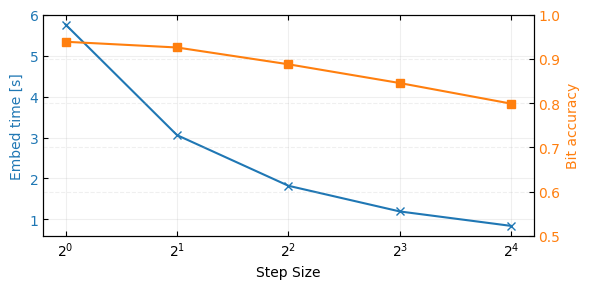

In [3]:
# df = pd.read_csv("/checkpoint/pfz/2025_logs/0304_vseal_eval_stepsize/expe/combined_metrics.csv")
# df = pd.read_csv("/checkpoint/pfz/2025_logs/0304_vseal_eval_stepsize_cpu/_checkpoint=0/combined_metrics.csv")

exp_dir = "/checkpoint/pfz/2025_logs/0306_vseal_eval_stepsize_bis"
exp_dir = "/checkpoint/pfz/2025_logs/0306_vseal_eval_stepsize"
dfs = {}
for ckpt in [0, 1]:
    df = pd.read_csv(f"{exp_dir}/_checkpoint={ckpt}/combined_metrics.csv")
    df = df.groupby(['step_size']).mean()
    df = df.reset_index()
    dfs[ckpt] = df
    display(df)


step_size_gpu = df['step_size'].values
embed_time = df['embed_time'].values / 3
bit_acc_combined = df['bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5)'].values

# Create a figure and a set of subplots
figsize = (6, 3)
fig, ax1 = plt.subplots(figsize=figsize)

# Plot embed time on CPU and GPU
colors = colors = plt.cm.tab10.colors
color = colors[0]
ax1.plot(step_size_gpu, embed_time, label='CPU time', color=color, marker='x')
ax1.set_xlabel('Step Size')
ax1.set_ylabel('Embed time [s]', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for bit accuracy
ax2 = ax1.twinx()
color = colors[1]
ax2.plot(step_size_gpu, bit_acc_combined, label='Bit acc. on combined', color=color, marker='s')
ax2.set_ylabel('Bit accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.5, 1.0)

# Add legends
# ax1.legend(loc='center left',  fontsize=9)
# ax2.legend(loc='center right', fontsize=9)
ax1.set_xscale('log', base=2)

# grid
ax1.grid(True)
ax2.grid(True, linestyle='--')

# Show the plot
# plt.title('Embed Time and Bit Accuracy vs Step Size')
plt.tight_layout()
plt.savefig('embed_time_bit_acc_vs_step_size.pdf')
plt.show()



"videowam_step_size": [1.0, 2.0, 4.0, 8.0, 16.0, 32.0],
"output_dir": ['/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas/_videowam_step_size=1', '/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas/_videowam_step_size=2', '/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas/_videowam_step_size=4', '/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas/_videowam_step_size=8', '/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas/_videowam_step_size=16', '/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas/_videowam_step_size=32'],
1/5: _videowam_step_size=1
2/5: _videowam_step_size=2
3/5: _videowam_step_size=4
4/5: _videowam_step_size=8
5/5: _videowam_step_size=16
Errors: 0 / 5


/tmp/ipykernel_67051/3531916212.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(


,videomode,step_size,checkpoint,PSNR,embed_time,VMAF,Valuemetric,Geometric,Compression,Combined,Average
0,repeat,1.0,videoseal,44.662288,1.070956,93.311666,0.996654,0.935018,0.909104,0.678202,0.913590
1,repeat,2.0,videoseal,44.672038,0.984720,93.271529,0.996600,0.929688,0.903035,0.667664,0.908859
2,repeat,4.0,videoseal,44.648574,0.922010,93.328026,0.995325,0.926626,0.894892,0.654643,0.903219
3,repeat,8.0,videoseal,44.634394,0.952183,93.413147,0.994258,0.915446,0.879790,0.634501,0.892345
4,repeat,16.0,videoseal,44.615013,0.780878,93.433404,0.987847,0.897339,0.862735,0.611796,0.877430


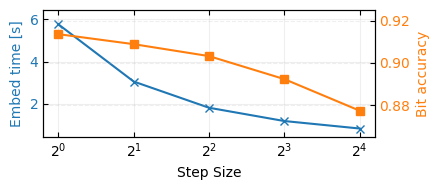

In [8]:
filters = {
    "videowam_step_size": [1.0, 2.0, 4.0, 8.0, 16.0],
}

all_exp_dir = "/checkpoint/pfz/2025_logs/0308_vseal_eval_stepsize_tomas"
params = read_params(os.path.join(all_exp_dir, 'params.txt'))

# additional expe
# all_exp_dir = "/checkpoint/pfz/2024_logs/1204_vseal_evalbaselines_singlescalingw_stepsize"
# params2 = read_params(os.path.join(all_exp_dir, 'params.txt'))
# params2 = {k+'2': v for k, v in params2.items()}
params2 = {}
params = {**params, **params2}

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f'"{k}": {v},')

# load dataframes
dfs = {}
list_scaling = []
errors = []
paths = filter_paths(params, filters)
for ii, path in enumerate(paths):
    print(f"{ii+1}/{len(paths)}: {path}")
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        print(f"{ii+1}/{len(paths)}: {exp_dir} - {path_exists} - {is_empty}")
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'), on_bad_lines='skip')
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['videomode'] = param['videowam_mode']
    metrics['step_size'] = param['videowam_step_size']  
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")


paths = dfs.keys()
levels = [df.index.nlevels for df in dfs.values()]
# remove df with df.index.nlevels != 1
dfs = {k: v for k, v in dfs.items() if v.index.nlevels == 1}
df = pd.concat(dfs)

# Process augmentations
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]

# Define augmentation categories
geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
identitic = ["identity"]
compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]  # Corrected to actual value-changing augmentations
combined = ["("]

# Map to actual augmentations in the dataset
identity_augs = [aug for aug in augs if any(aug.lower().startswith(i) for i in identitic)]
geometric_augs = [aug for aug in augs if any(aug.lower().startswith(g) for g in geometric)]
compression_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in compression)]
valuemetric_augs = [aug for aug in augs if any(aug.lower().startswith(v) for v in valuemetric)]
combined_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in combined)]
all_augs = identity_augs + geometric_augs + compression_augs + valuemetric_augs + combined_augs

# Function to calculate average bit accuracy for augmentation types
def calculate_average(df_subset, augs_list):
    cols = [f'bit_acc_{aug}' for aug in augs_list if f'bit_acc_{aug}' in df_subset.columns]
    if not cols:
        return float('nan')
    return df_subset[cols].mean(axis=1).mean()

# Group by videomode and calculate means
all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(
    lambda x: pd.Series({
        'PSNR': x['psnr'].mean(),
        'embed_time': x['embed_time'].mean(),
        'VMAF': x['vmaf'].mean() if 'vmaf' in x else float('nan'),
        'Valuemetric': calculate_average(x, valuemetric_augs),
        'Geometric': calculate_average(x, geometric_augs),
        'Compression': calculate_average(x, compression_augs),
        'Combined': calculate_average(x, combined_augs),
        'Average': calculate_average(x, all_augs),
    })
).reset_index()
display(all_grouped)

step_sizes = all_grouped['step_size'].unique()
bit_acc_avg = all_grouped.groupby('step_size')['Average'].mean()
# embed_time = all_grouped.groupby('step_size')['embed_time'].mean()

# Create a figure and a set of subplots
figsize = (4.5, 2)
fig, ax1 = plt.subplots(figsize=figsize)

# Plot embed time on CPU and GPU
colors = colors = plt.cm.tab10.colors
color = colors[0]
ax1.plot(step_sizes, embed_time, label='CPU time', color=color, marker='x')
ax1.set_xlabel('Step Size')
ax1.set_ylabel('Embed time [s]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.44, 6.44)

# Create a second y-axis for bit accuracy
ax2 = ax1.twinx()
color = colors[1]
ax2.plot(step_sizes, bit_acc_avg, label='Bit acc. on combined', color=color, marker='s')
ax2.set_ylabel('Bit accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.865, 0.925)
# ax2.yaxis.set_major_locator(plt.MaxNLocator(7))

# Add legends
# ax1.legend(loc='center left',  fontsize=9)
# ax2.legend(loc='center right', fontsize=9)
ax1.set_xscale('log', base=2)

# grid
ax1.grid(True)
ax2.grid(True, linestyle='--')

# Show the plot
# plt.title('Embed Time and Bit Accuracy vs Step Size')
plt.tight_layout()
plt.savefig('embed_time_bit_acc_vs_step_size.pdf')
plt.show()





## Video Mode

In [128]:
filters = {
    # "checkpoint": ['/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth'],
    # "videowam_mode": ['repeat', 'interpolate', 'alternate'],
    # "videowam_step_size": [1.0, 4.0],
    "checkpoint": ['/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth'],
}

# load params and filter
# all_exp_dir = "/checkpoint/pfz/2025_logs/0303_vseal_eval_videomode"
# all_exp_dir = "/checkpoint/pfz/2025_logs/0306_vseal_eval_videomode"
all_exp_dir = "/checkpoint/pfz/2025_logs/0307_vseal_eval_videomode_tomas"
params = read_params(os.path.join(all_exp_dir, 'params.txt'))

# additional expe
# all_exp_dir = "/checkpoint/pfz/2024_logs/1204_vseal_evalbaselines_singlescalingw_stepsize"
# params2 = read_params(os.path.join(all_exp_dir, 'params.txt'))
# params2 = {k+'2': v for k, v in params2.items()}
params2 = {}
params = {**params, **params2}

# print sweepable parameters
sweepable = sweepable_params(params)
for k, v in sweepable.items():
    print(f'"{k}": {v},')

# load dataframes
dfs = {}
list_scaling = []
errors = []
paths = filter_paths(params, filters)
for ii, path in enumerate(paths):
    print(f"{ii+1}/{len(paths)}: {path}")
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        print(f"{ii+1}/{len(paths)}: {exp_dir} - {path_exists} - {is_empty}")
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'), on_bad_lines='skip')
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['videomode'] = param['videowam_mode']
    metrics['step_size'] = param['videowam_step_size']  
    dfs[path] = metrics
print(f"Errors: {len(errors)} / {len(paths)}")


paths = dfs.keys()
levels = [df.index.nlevels for df in dfs.values()]
# remove df with df.index.nlevels != 1
dfs = {k: v for k, v in dfs.items() if v.index.nlevels == 1}
df = pd.concat(dfs)
measures = [
    "checkpoint",
    "step_size",
    "psnr", "ssim", 
    "vmaf", 
    "videomode",
    "embed_time", "extract_time",
]
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]
new_augs = [aug for aug in augs if aug.startswith("(")]
for aug in new_augs:
    measures.append(f'bit_acc_{aug}')
    measures.append(f'log_pvalue_{aug}')
    measures.append(f'capacity_{aug}')

df = df[measures]
df = df.groupby(['checkpoint', "step_size", "videomode"]).mean()
df = df.reset_index()

checkpoints = list(checkpoint_mapping.keys())
# new_augs = augs

df

"checkpoint": ['/checkpoint/pfz/2025_logs/0225_vseal_ydisc_with_jnd/_balanced=False_scaling_w=1.0/checkpoint450.pth', '/checkpoint/soucek/2025_logs/0228_vseal_128bits_jnd_ftvid_complete/_optimizer=AdamW,lr=1e-5_videowam_step_size=1/checkpoint200.pth'],
"videowam_mode": ['repeat', 'interpolate', 'alternate'],
"videowam_step_size": [1.0, 4.0],
"output_dir": ['/checkpoint/pfz/2025_logs/0307_vseal_eval_videomode_tomas/_checkpoint=0_videowam_mode=repeat_videowam_step_size=1', '/checkpoint/pfz/2025_logs/0307_vseal_eval_videomode_tomas/_checkpoint=0_videowam_mode=repeat_videowam_step_size=4', '/checkpoint/pfz/2025_logs/0307_vseal_eval_videomode_tomas/_checkpoint=0_videowam_mode=interpolate_videowam_step_size=4', '/checkpoint/pfz/2025_logs/0307_vseal_eval_videomode_tomas/_checkpoint=0_videowam_mode=alternate_videowam_step_size=4', '/checkpoint/pfz/2025_logs/0307_vseal_eval_videomode_tomas/_checkpoint=1_videowam_mode=repeat_videowam_step_size=1', '/checkpoint/pfz/2025_logs/0307_vseal_eval_video

,checkpoint,step_size,videomode,psnr,ssim,vmaf,embed_time,extract_time,bit_acc_(H264_Crop_Brightness)_(23_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(23_0.71_0.5),capacity_(H264_Crop_Brightness)_(23_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(30_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(30_0.71_0.5),capacity_(H264_Crop_Brightness)_(30_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(40_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(40_0.71_0.5),capacity_(H264_Crop_Brightness)_(40_0.71_0.5),bit_acc_(H264_Crop_Brightness)_(50_0.71_0.5),log_pvalue_(H264_Crop_Brightness)_(50_0.71_0.5),capacity_(H264_Crop_Brightness)_(50_0.71_0.5)
0,videoseal,1.0,repeat,44.654475,0.992619,93.354713,1.090899,0.360950,0.842529,15.831909,49.568308,0.786865,11.693733,35.872358,0.570719,1.797769,4.292729,0.506836,0.491807,0.905662
1,videoseal,4.0,alternate,50.678539,0.998155,94.020423,0.985300,0.383615,0.763835,10.477539,31.915258,0.686523,6.264693,18.248761,0.546143,1.183663,2.477789,0.503825,0.447071,0.818863
2,videoseal,4.0,interpolate,45.430775,0.993285,93.563721,0.953796,0.378587,0.804281,12.733185,39.279987,0.739746,8.914843,26.789312,0.559977,1.545079,3.562517,0.496663,0.381315,0.786789
3,videoseal,4.0,repeat,44.657506,0.992680,93.409492,0.867541,0.355743,0.806966,12.900193,39.819786,0.741048,9.064786,27.258528,0.568115,1.801721,4.338933,0.510417,0.472392,0.666868


In [129]:

# Define geometric and valuemetric augmentations
geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
identitic = ["identity"]
compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]

# Load dataframes
dfs = {}
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        print(path)
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'), on_bad_lines='skip')
    print(f"{path} has {len(metrics)} rows")
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['videomode'] = param['videowam_mode'] if 'videowam_mode' in param else 'repeat'  # Default to 'repeat'
    metrics['step_size'] = param['videowam_step_size'] if 'videowam_step_size' in param else 1.0  # Default to 1.0
    dfs[path] = metrics

print(f"Errors: {len(errors)} / {len(paths)}")

# Combine dataframes
df = pd.concat(dfs.values())

# Process augmentations
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]

# Map to actual augmentations in the dataset
identity_augs = [aug for aug in augs if any(aug.lower().startswith(i) for i in identitic)]
geometric_augs = [aug for aug in augs if any(aug.lower().startswith(g) for g in geometric)]
compression_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in compression)]
valuemetric_augs = [aug for aug in augs if any(aug.lower().startswith(v) for v in valuemetric)]
# h264_augs = [aug for aug in augs if aug.lower().startswith('h264') and not aug.lower().startswith('h264rgb')]
# h265_augs = [aug for aug in augs if aug.lower().startswith('h265')]
# h264rgb_augs = [aug for aug in augs if aug.lower().startswith('h264rgb')]
h264_augs = [aug for aug in augs if aug.lower().startswith('h264_50')]
h265_augs = [aug for aug in augs if aug.lower().startswith('h265_50')]
h264rgb_augs = [aug for aug in augs if aug.lower().startswith('h264rgb_50')]

# Function to calculate average bit accuracy for augmentation types
def calculate_average(df_subset, augs_list):
    cols = [f'bit_acc_{aug}' for aug in augs_list if f'bit_acc_{aug}' in df_subset.columns]
    if not cols:
        return float('nan')
    return df_subset[cols].mean(axis=1).mean()

# Group by videomode and calculate means
all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(
    lambda x: pd.Series({
        'PSNR': x['psnr'].mean(),
        'VMAF': x['vmaf'].mean() if 'vmaf' in x else float('nan'),
        'Valuemetric': calculate_average(x, valuemetric_augs),
        'Geometric': calculate_average(x, geometric_augs),
        'H264': calculate_average(x, h264_augs),
        'H265': calculate_average(x, h265_augs),
        'H264rgb': calculate_average(x, h264rgb_augs)
    })
).reset_index()

# Map videomode to more readable labels
mode_mapping = {
    'repeat': 'Copy',
    'alternate': 'Every $k$',
    'interpolate': 'Interpolate'
}
all_grouped['Mode'] = all_grouped['videomode'].map(mode_mapping)

for checkpoint in all_grouped['checkpoint'].unique():
    
    print(f"\nCheckpoint: {checkpoint}")
    grouped = all_grouped[all_grouped['checkpoint'] == checkpoint]

    # Format the table
    latex_table = r"""
\begin{tabular}{l cc *{5}{c}}
\toprule
& \multicolumn{2}{c}{Quality} & \multicolumn{5}{c}{Bit Accuracy} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-8}
Mode & PSNR & VMAF & Valuem. & Geom. & H.264 & H.265 & H.264\textsubscript{rgb} \\
\midrule"""

    # Add rows for each mode
    for mode in ['Every $k$', 'Copy', 'Interpolate']:
        mode_data = grouped[grouped['Mode'] == mode]
        if len(mode_data) == 0:
            # If no data for this mode, add NA row
            latex_table += f"{mode} & NA & NA & NA & NA & NA & NA & NA \\\\\n"
        else:
            for _, row in mode_data.iterrows():
                latex_table += f"{mode} ({int(row['step_size'])}) & {row['PSNR']:.2f} & {row['VMAF']:.2f} & "
                latex_table += f"{row['Valuemetric']:.2f} & {row['Geometric']:.2f} & "
                latex_table += f"{row['H264']:.2f} & {row['H265']:.2f} & {row['H264rgb']:.2f} \\\\\n"

    # Close the table
    latex_table += r"\bottomrule" + "\n"
    latex_table += r"\end{tabular}"

    # Print and save the table
    print(latex_table)

    with open(f"tables/video_modes_comparison.tex", "w") as f:
        f.write(latex_table)

_checkpoint=1_videowam_mode=repeat_videowam_step_size=1 has 96 rows
_checkpoint=1_videowam_mode=repeat_videowam_step_size=4 has 96 rows
_checkpoint=1_videowam_mode=interpolate_videowam_step_size=4 has 96 rows
_checkpoint=1_videowam_mode=alternate_videowam_step_size=4 has 96 rows
Errors: 0 / 4

Checkpoint: videoseal

\begin{tabular}{l cc *{5}{c}}
\toprule
& \multicolumn{2}{c}{Quality} & \multicolumn{5}{c}{Bit Accuracy} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-8}
Mode & PSNR & VMAF & Valuem. & Geom. & H.264 & H.265 & H.264\textsubscript{rgb} \\
\midruleEvery $k$ (4) & 50.68 & 94.02 & 1.00 & 0.93 & 0.56 & 0.55 & 0.75 \\
Copy (1) & 44.65 & 93.35 & 1.00 & 0.93 & 0.59 & 0.60 & 0.85 \\
Copy (4) & 44.66 & 93.41 & 1.00 & 0.93 & 0.57 & 0.58 & 0.81 \\
Interpolate (4) & 45.43 & 93.56 & 1.00 & 0.93 & 0.57 & 0.58 & 0.81 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_4011090/3533115059.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(


In [130]:

# Define geometric and valuemetric augmentations
geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
identitic = ["identity"]
compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]
combined = ["(H264_Crop_Brightness)_(30_0.71_0.5)", "(H264_Crop_Brightness)_(40_0.71_0.5)", "(H264_Crop_Brightness)_(50_0.71_0.5)"]

# Load dataframes
dfs = {}
errors = []
for ii, path in enumerate(paths):
    param = params[path]
    exp_dir = param['output_dir']
    path_exists = os.path.exists(os.path.join(exp_dir, 'metrics.csv'))
    is_empty = not path_exists or os.path.getsize(os.path.join(exp_dir, 'metrics.csv')) == 0
    if not path_exists or is_empty:
        print(path)
        errors.append(path)
        continue
    metrics = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'), on_bad_lines='skip')
    if len(metrics) < 50:
        print(f"{path} has {len(metrics)} rows")
    metrics['checkpoint'] = get_ckpt(param['checkpoint'])
    metrics['videomode'] = param['videowam_mode'] if 'videowam_mode' in param else 'repeat'  # Default to 'repeat'
    metrics['step_size'] = param['videowam_step_size'] if 'videowam_step_size' in param else 1.0  # Default to 1.0
    dfs[path] = metrics

print(f"Errors: {len(errors)} / {len(paths)}")

# Combine dataframes
df = pd.concat(dfs.values())

# Process augmentations
augs = list(df.columns)
augs = [c.replace('bit_acc_', '') for c in augs if c.startswith('bit_acc')]

# Define augmentation categories
geometric = ["rotate", "perspective", "crop", "horizontal", "resize"]
identitic = ["identity"]
compression = ["jpeg", "h264rgb", "h264", "h265", "vp9"]
valuemetric = ["brightness", "contrast", "hue", "saturation", "gaussianblur", "grayscale"]  # Corrected to actual value-changing augmentations
combined = ["("]


# Map to actual augmentations in the dataset
identity_augs = [aug for aug in augs if any(aug.lower().startswith(i) for i in identitic)]
geometric_augs = [aug for aug in augs if any(aug.lower().startswith(g) for g in geometric)]
compression_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in compression)]
valuemetric_augs = [aug for aug in augs if any(aug.lower().startswith(v) for v in valuemetric)]
combined_augs = [aug for aug in augs if any(aug.lower().startswith(c) for c in combined)]

# Function to calculate average bit accuracy for augmentation types
def calculate_average(df_subset, augs_list):
    cols = [f'bit_acc_{aug}' for aug in augs_list if f'bit_acc_{aug}' in df_subset.columns]
    if not cols:
        return float('nan')
    return df_subset[cols].mean(axis=1).mean()

# Group by videomode and calculate means
all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(
    lambda x: pd.Series({
        'PSNR': x['psnr'].mean(),
        'VMAF': x['vmaf'].mean() if 'vmaf' in x else float('nan'),
        'Valuemetric': calculate_average(x, valuemetric_augs),
        'Geometric': calculate_average(x, geometric_augs),
        'Compression': calculate_average(x, compression_augs),
        'Combined': calculate_average(x, combined_augs)
    })
).reset_index()

# Map videomode to more readable labels
mode_mapping = {
    'repeat': 'Copy',
    'alternate': 'Every $k$',
    'interpolate': 'Interpolate'
}
all_grouped['Mode'] = all_grouped['videomode'].map(mode_mapping)

for checkpoint in all_grouped['checkpoint'].unique():
    
    print(f"\nCheckpoint: {checkpoint}")
    grouped = all_grouped[all_grouped['checkpoint'] == checkpoint]
    # Format the table
    latex_table = r"""
\begin{tabular}{l c cc *{4}{c}}
\toprule
& $k$ & \multicolumn{2}{c}{Quality} & \multicolumn{4}{c}{Bit Accuracy} \\
\cmidrule(lr){3-4} \cmidrule(lr){5-8}
Mode & & PSNR & VMAF & Valuem. & Geom. & Comp. & Combined \\
\midrule
"""

    # Add rows for each mode
    for mode in ['Every $k$', 'Copy', 'Interpolate']:
        mode_data = grouped[grouped['Mode'] == mode]
        if len(mode_data) == 0:
            # If no data for this mode, add NA row
            latex_table += f"{mode} & NA & NA & NA & NA & NA & NA & NA & NA \\\\\n"
        else:
            for _, row in mode_data.iterrows():
                latex_table += f"{mode} & {int(row['step_size'])} & {row['PSNR']:.2f} & {row['VMAF']:.2f} & "
                latex_table += f"{row['Valuemetric']:.2f} & {row['Geometric']:.2f} & "
                latex_table += f"{row['Compression']:.2f} & {row['Combined']:.2f} \\\\\n"

    # Close the table
    latex_table += r"\bottomrule" + "\n"
    latex_table += r"\end{tabular}"

    # Print and save the table
    print(latex_table)

    with open(f"tables/video_modes_comparison.tex", "w") as f:
        f.write(latex_table)


Errors: 0 / 4

Checkpoint: videoseal

\begin{tabular}{l c cc *{4}{c}}
\toprule
& $k$ & \multicolumn{2}{c}{Quality} & \multicolumn{4}{c}{Bit Accuracy} \\
\cmidrule(lr){3-4} \cmidrule(lr){5-8}
Mode & & PSNR & VMAF & Valuem. & Geom. & Comp. & Combined \\
\midrule
Every $k$ & 4 & 50.68 & 94.02 & 1.00 & 0.93 & 0.86 & 0.63 \\
Copy & 1 & 44.65 & 93.35 & 1.00 & 0.93 & 0.91 & 0.68 \\
Copy & 4 & 44.66 & 93.41 & 1.00 & 0.93 & 0.90 & 0.66 \\
Interpolate & 4 & 45.43 & 93.56 & 1.00 & 0.93 & 0.90 & 0.65 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_4011090/1194430155.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_grouped = df.groupby(['videomode', 'step_size', 'checkpoint']).apply(


## Ablation on architectures

In [ ]:
all_exp_dir = "/checkpoint/pfz/2025_logs/0228_vseal_arch_abl"
filters = {
} 

# load params and filter
params = read_params(os.path.join(all_exp_dir, 'params.txt'))
paths = filter_paths(params, filters)

# print sweepable parameters
sweepable = sweepable_params(params)
# sweepable = {f'"{k}"=[{", ".join(v)}]' for k, v in sweepable.items()}
for k, v in sweepable.items():
    print(f'"{k}":{v},')

# load dataframes
dfs = {}
list_scaling = []
for ii, path in enumerate(paths):
    exp_dir = os.path.join(all_exp_dir, path)
    param = params[path]
    try:
        logs = parse_logs(os.path.join(exp_dir, 'log.txt'), '')
        dfs[path] = pd.DataFrame.from_dict(logs).transpose()
    except:
        print(f"{path} is not found")

paths = dfs.keys()
try:
    epoch = max(dfs[path]['epoch'])
except:
    epoch=0
epoch = int(epoch - epoch % 5)
max_epoch = 2000

# # blue colors
# cmap = plt.get_cmap('Blues')
# colors = [cmap(i) for i in np.linspace(0.1, 1, len(paths))]

# 20 different colors
colors = plt.cm.tab20.colors
# colors = colors[::2] + colors[1::2]
# colors = colors[:6:2] + colors[1:6:2]

# colormaps = {
#     'red': plt.cm.Reds,
#     'purple': plt.cm.Purples,
#     'blue': plt.cm.Blues,
#     'green': plt.cm.Greens,
# }
# # Number of levels
# levels = 4
# # Generate colors
# colors = {name: [cmap((ii+1) / levels) for ii in range(levels)] for name, cmap in colormaps.items()}
# flattened_colors = []
# for level in range(levels):
#     for name in colormaps.keys():
#         flattened_colors.append(colors[name][level])
# colors = flattened_colors

def plot_measure(measures, title=None, marker=None, ncols=8, epoch_range=None):
    if len(measures) > ncols:
        ncols = ncols
        nrows = (len(measures) + ncols-1) // ncols  # Calculate the number of rows needed
    else:
        ncols = len(measures)
        nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for ii, path in enumerate(paths):
        df = dfs[path]
        param = params[path]
        for jj, measure in enumerate(measures):
            ax = axes[jj]
            if measure not in df.columns:
                print(f"{measure} not found in {path}")
                continue
            df_measure = df.copy().dropna(subset=[measure])
            if epoch_range is not None:
                df_measure = df_measure[(df_measure['epoch'] >= epoch_range[0]) & (df_measure['epoch'] <= epoch_range[1])]
            ax.plot(
                df_measure['epoch'], df_measure[measure], 
                label=f"{path.replace('_', '')}",
                color=colors[ii],
                marker=marker,
            )
            ylabel = measure.replace('_', ' ').capitalize()
            ax.set_ylabel(ylabel, fontsize=8)
            xlabel = 'Epoch'
            ax.set_xlabel(xlabel)
            ax.grid(True)
    if title is not None:
        plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    ax.legend(loc='upper right', bbox_to_anchor=(1.04, -0.1), fontsize=16, ncol=1, fancybox=True, shadow=True)
    plt.show()

# print(dfs)

measures = ['train_lr', 'train_total_loss', 'train_loss_disc', 'train_loss_percep', 'train_loss_decode', 'train_psnr', 'train_bit_acc']
plot_measure(measures)

measures = ['val_img_bit_acc_mask=0_aug=Identity_0', 'val_img_bit_acc_mask=0_aug=Crop_0.71', 'val_img_bit_acc_mask=0_aug=Rotate_90', 'val_img_bit_acc_mask=0_aug=JPEG_60', 'val_img_bit_acc_mask=0_aug=Brightness_0.5', 'val_img_bit_acc_mask=0_aug=(JPEG_Crop_Brightness)_(60_0.71_0.5)']
plot_measure(measures)

# measures = ['val_vid_bit_acc_mask=0_aug=Identity_0', 'val_vid_bit_acc_mask=0_aug=H264_40', 'val_vid_bit_acc_mask=0_aug=Crop_0.71', 'val_vid_bit_acc_mask=0_aug=Brightness_0.5', 'val_vid_bit_acc_mask=0_aug=(H264_Crop_Brightness)_(40_0.71_0.5)']
# plot_measure(measures, marker='+')

In [ ]:
embedders = ['U-Net', 'VAE', 'HiDDeN']
extractors = ['ConvNeXt', 'ViT', 'HiDDeN']
labels = [f"{embedder} + {extractor}" for extractor in extractors for embedder in embedders ]

colors = plt.cm.tab20.colors[::2]
colors = [colors[0],colors[0],colors[0], colors[1],colors[1],colors[1], colors[2],colors[2],colors[2]]
linestyles = ['-', '--', '-.', '-', '--', '-.', '-', '--', '-.']

measures = ["train_total_loss", "train_bit_acc", "val_img_bit_acc_mask=0_aug=Identity_0", "val_img_bit_acc_mask=0_aug=Crop_0.71"]
masure_labels = ["Training Loss", "Training Bit Accuracy", "Validation Bit Accuracy (Identity)", "Validation Bit Accuracy (Crop)"]

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ii, measure in enumerate(measures):
    ax = axes[ii]
    for jj, path in enumerate(paths):
        df = dfs[path]
        param = params[path]
        df_measure = df.copy().dropna(subset=[measure])
        ax.plot(
            df_measure['epoch'], df_measure[measure], 
            label=f"{labels[jj]}",
            color=colors[jj],
            linestyle=linestyles[jj],
        )
        ax.set_ylabel(masure_labels[ii], fontsize=10)
        ax.set_xlabel('Epoch', fontsize=10)
        if "bit_acc" in measure:
            ax.set_ylim(0.47, 1.03)
        # x lim between 0 and 300
        ax.set_xlim(0, 300)

plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("arch_abl.pdf", bbox_inches='tight')
plt.show()


## Latency

In [183]:
# Define the dictionaries
gflops_embed = {
    "hidden": 22.4,
    "mbrs": 32.2,
    "cin": 16.6,
    "trustmark": 10.3,
    "wam": 42.6,
    "videoseal": 56.5,
}
gflops_extract = {
    "hidden": 39.0,
    "mbrs": 27.0,
    "cin": 17.9,
    "trustmark": 4.1,
    "wam": 68.7,
    "videoseal": 12.3,
}

embed_cpu = {}
extract_cpu = {}
device = "cpu"
results_csv = f"/private/home/pfz/09-videoseal/videoseal-dev/output/speed_{device}/speed_results.csv"
results = pd.read_csv(results_csv)
results["model_name"] = results["checkpoint"].apply(lambda x: get_ckpt(x))
results["embed_time"] = results["Embed ms/frame"] * 24
results["extract_time"] = results["Extract ms/frame"] * 24
for model in results["model_name"].unique():
    embed_cpu[model] = results[results["model_name"] == model]["embed_time"].values[0]
    extract_cpu[model] = results[results["model_name"] == model]["extract_time"].values[0]

embed_gpu = {}
extract_gpu = {}
device = "gpu"
results_csv = f"/private/home/pfz/09-videoseal/videoseal-dev/output/speed_{device}/speed_results.csv"
results = pd.read_csv(results_csv)
results["model_name"] = results["checkpoint"].apply(lambda x: get_ckpt(x))
results["embed_time"] = results["Embed ms/frame"] * 24
results["extract_time"] = results["Extract ms/frame"] * 24
for model in results["model_name"].unique():
    embed_gpu[model] = results[results["model_name"] == model]["embed_time"].values[0]
    extract_gpu[model] = results[results["model_name"] == model]["extract_time"].values[0]

# Map model names to their corresponding display names and citations
model_map = {
    "hidden": ("HiDDeN", "\\citep{zhu2018hidden}"),
    "mbrs": ("MBRS", "\\citep{jia2021mbrs}"),
    "cin": ("CIN", "\\citep{ma2022towards}"),
    "trustmark": ("TrustMark", "\\citep{bui2023trustmark}"),
    "wam": ("WAM", "\\citep{sander2024watermark}"),
    "videoseal": ("\\ours", "(ours)"),
}

# Generate the table
print("\\begin{tabular}{rr *{6}{c}}")
print("\\toprule")

# Print the header row
header_row = "& & " + " & ".join([f"\\rotatebox[origin=l]{{0}}{{\\shortstack[c]{{{display_name}\\\\ {{\\footnotesize {citation}}}}}}}" for display_name, citation in model_map.values()]) + " \\\\"
print(header_row)

print("\\midrule")
# Print the embed rows
print("\\multirow{3}{*}{\\rotatebox[origin=c]{90}{Embed}} ")

embed_rows = [
    "& GFlops & " + " & ".join([f"{gflops_embed[model] :.1f}" for model in model_map]) + " \\\\ ",
    "& CPU - Time (s) & " + " & ".join([f"{embed_cpu[model] / 1000:.2f}" for model in model_map]) + " \\\\ ",
    "& GPU - Time (s) & " + " & ".join([f"{embed_gpu[model] / 1000:.2f}" for model in model_map]) + " \\\\ "
]

print("\n".join(embed_rows))
print("\\midrule")

# Print the extract rows
print("\\multirow{3}{*}{\\rotatebox[origin=c]{90}{Extract}} ")

extract_rows = [
    "& GFlops & " + " & ".join([f"{gflops_extract[model] :.1f}" for model in model_map]) + " \\\\ ",
    "& CPU - Time (s) & " + " & ".join([f"{extract_cpu[model] / 1000:.2f}" for model in model_map]) + " \\\\ ",
    "& GPU - Time (s) & " + " & ".join([f"{extract_gpu[model] / 1000:.2f}" for model in model_map]) + " \\\\ "
]

print("\n".join(extract_rows))
print("\\bottomrule")
print("\\end{tabular}")


\begin{tabular}{rr *{6}{c}}
\toprule
& & \rotatebox[origin=l]{0}{\shortstack[c]{HiDDeN\\ {\footnotesize \citep{zhu2018hidden}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{MBRS\\ {\footnotesize \citep{jia2021mbrs}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{CIN\\ {\footnotesize \citep{ma2022towards}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{TrustMark\\ {\footnotesize \citep{bui2023trustmark}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{WAM\\ {\footnotesize \citep{sander2024watermark}}}} & \rotatebox[origin=l]{0}{\shortstack[c]{\ours\\ {\footnotesize (ours)}}} \\
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{Embed}} 
& GFlops & 22.4 & 32.2 & 16.6 & 10.3 & 42.6 & 56.5 \\ 
& CPU - Time (s) & 1.08 & 2.58 & 0.99 & 1.03 & 1.41 & 1.13 \\ 
& GPU - Time (s) & 0.74 & 0.80 & 0.74 & 0.76 & 0.78 & 0.57 \\ 
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{Extract}} 
& GFlops & 39.0 & 27.0 & 17.9 & 4.1 & 68.7 & 12.3 \\ 
& CPU - Time (s) & 1.93 & 2.67 & 2.37 & 0.51 & 2.92 & 1.28 \\ 
& GPU - Time (

In [165]:

import os
import cv2
from tqdm import tqdm

def count_frames_in_videos(video_dir):
    """
    Count frames in all videos in the specified directory.
    
    Args:
        video_dir (str): Path to directory containing video files
        
    Returns:
        dict: Dictionary mapping video filenames to their frame counts
    """
    # Get list of video files
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
    video_files.sort()
    
    # Dictionary to store results
    frame_counts = {}
    
    # Process each video
    for video_file in tqdm(video_files, desc="Counting frames"):
        video_path = os.path.join(video_dir, video_file)
        
        try:
            # Open video file
            cap = cv2.VideoCapture(video_path)
            
            # Get frame count using CAP_PROP_FRAME_COUNT
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Store result
            frame_counts[video_file] = frame_count
            
            # Release video capture
            cap.release()
            
        except Exception as e:
            print(f"Error processing {video_file}: {str(e)}")
            frame_counts[video_file] = -1
            
    return frame_counts

def print_frame_counts(frame_counts):
    """
    Print frame counts in a formatted way.
    """
    print("\nFrame counts for each video:")
    print("-" * 50)
    print(f"{'Video File':<40} {'Frame Count':>10}")
    print("-" * 50)
    
    for video_file, count in frame_counts.items():
        print(f"{video_file:<40} {count:>10}")
        
    # Print summary statistics
    valid_counts = [count for count in frame_counts.values() if count > 0]
    if valid_counts:
        print("\nSummary Statistics:")
        print(f"Total videos: {len(frame_counts)}")
        print(f"Average frames: {sum(valid_counts)/len(valid_counts):.1f}")
        print(f"Min frames: {min(valid_counts)}")
        print(f"Max frames: {max(valid_counts)}")

video_dir = "/large_experiments/omniseal/moviegen-full"

# Verify directory exists
if not os.path.exists(video_dir):
    print(f"Error: Directory {video_dir} does not exist")
    exit(1)
    
# Count frames
frame_counts = count_frames_in_videos(video_dir)

# Print results
print_frame_counts(frame_counts)

Counting frames: 100%|██████████| 121/121 [00:03<00:00, 39.13it/s]


Frame counts for each video:
--------------------------------------------------
Video File                               Frame Count
--------------------------------------------------
000.mp4                                         256
001.mp4                                         256
002.mp4                                         256
003.mp4                                         256
004.mp4                                         250
005.mp4                                         256
006.mp4                                         257
007.mp4                                         250
008.mp4                                         250
009.mp4                                         250
010.mp4                                         256
011.mp4                                         250
012.mp4                                         250
013.mp4                                         256
014.mp4                                         256
015.mp4                            